# **Augmentations** - Added augmentation dataset

In [15]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset

train_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
test_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


class AugmentationsDataset(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.dataset[index]
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img)
        return img1, img2, target

    def __len__(self):
        return len(self.dataset)

# **Models**


In [16]:
import torch
import torch.nn as nn
from torchvision.models import resnet18


class Encoder(nn.Module):
    def __init__(self, D=128, device='cuda'):
        super(Encoder, self).__init__()
        self.resnet = resnet18(pretrained=False).to(device)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Linear(512, 512)
        self.fc = nn.Sequential(nn.BatchNorm1d(512), nn.ReLU(inplace=True), nn.Linear(512, D))

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

    def encode(self, x):
        return self.forward(x)


class Projector(nn.Module):
    def __init__(self, D, proj_dim=512):
        super(Projector, self).__init__()
        self.model = nn.Sequential(nn.Linear(D, proj_dim),
                                   nn.BatchNorm1d(proj_dim),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(proj_dim, proj_dim),
                                   nn.BatchNorm1d(proj_dim),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(proj_dim, proj_dim)
                                   )

    def forward(self, x):
        return self.model(x)


class VicReg(nn.Module):
    def __init__(self, D=128, proj_dim=512, device='cuda'):
        super(VicReg, self).__init__()
        self.encoder = Encoder(D, device)
        self.projector = Projector(D, proj_dim)
        self.device = device

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        z1 = self.projector(z1)
        z2 = self.projector(z2)
        return z1, z2

    def encode(self, x):
        return self.encoder.encode(x)

    def proj(self, x):
        return self.projector(x)

# **Imports**

In [17]:
from tqdm.notebook import tqdm
import numpy as np
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

# **VICREG Training**

In [2]:
def calculate_var_and_cov_loss(z, epsilon, gamma):
    N, D = z.shape

    # Calculate variance loss
    var = torch.var(z, dim=0)
    std = torch.sqrt(var + epsilon)
    var_loss = torch.mean(torch.max(torch.zeros_like(std), gamma - std))

    # Calculate covariance loss
    z_mean = torch.mean(z, dim=0)
    z_centered = z - z_mean.unsqueeze(0)
    cov = (z_centered.T @ z_centered) / (N - 1)
    off_diag = cov * (1 - torch.eye(D, device=cov.device))
    cov_loss = (off_diag ** 2).sum() / D

    return var_loss, cov_loss


def train_vicreg(train_set, test_set, batch_size=256, epochs=100, lr=(3*1e-4), device='cuda', mu=25, title=''):
    gamma = 1
    epsilon = 1e-4
    lambd = 25
    mu = mu
    v = 1
    projection_dim = 512
    encoder_dim = 128

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2) if test_set else None

    model = VicReg(encoder_dim, projection_dim, device).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(),lr = lr ,betas = (0.9,0.999),weight_decay = 1e-6)
    mse_loss = nn.MSELoss()


    train_total_loss = []
    train_inv_loss = []
    train_var_loss = []
    train_cov_loss = []

    test_total_loss = []
    test_inv_loss = []
    test_var_loss = []
    test_cov_loss = []

    for epoch in tqdm(range(1, epochs+1), desc="Training Progress"): 
        model.train()
        ep_train_total_loss = []
        ep_train_inv_loss = []
        ep_train_var_loss = []
        ep_train_cov_loss = []

        for i, (img1, img2, _) in tqdm(enumerate(train_loader), desc="Train Epoch Progress", total=len(train_loader), leave=False, position=0):
            img1, img2 = img1.to(device), img2.to(device)
            optimizer.zero_grad()
            z1, z2 = model(img1, img2)

            # Calculate invariant loss
            inv_loss = lambd * mse_loss(z1, z2)

            # Calculate variance and covariance loss
            var_loss1, cov_loss1 = calculate_var_and_cov_loss(z1, epsilon, gamma)
            var_loss2, cov_loss2 = calculate_var_and_cov_loss(z2, epsilon, gamma)

            var_loss = mu * (var_loss1 + var_loss2)
            cov_loss = v * (cov_loss1 + cov_loss2)

            # Calculate total loss
            loss = inv_loss + var_loss + cov_loss

            ep_train_total_loss.append(loss.item())
            ep_train_inv_loss.append(inv_loss.item())
            ep_train_var_loss.append(var_loss.item())
            ep_train_cov_loss.append(cov_loss.item())
            loss.backward()
            optimizer.step()

        train_mean_total_loss = np.mean(ep_train_total_loss)
        train_mean_inv_loss = np.mean(ep_train_inv_loss)
        train_mean_var_loss = np.mean(ep_train_var_loss)
        train_mean_cov_loss = np.mean(ep_train_cov_loss)

        train_total_loss.append(train_mean_total_loss)
        train_inv_loss.append(train_mean_inv_loss)
        train_var_loss.append(train_mean_var_loss)
        train_cov_loss.append(train_mean_cov_loss)

        tqdm.write(f'Epoch {epoch}/{epochs} Loss: {train_mean_total_loss},' 
            f'Invariant Loss: {train_mean_inv_loss}, '
            f'Variance Loss: {train_mean_var_loss}, '
            f'Covariance Loss: {train_mean_cov_loss}')
        
        if not test_set:
            continue
        ep_test_total_loss = []
        ep_test_inv_loss = []
        ep_test_var_loss = []
        ep_test_cov_loss = []

        model.eval()
        with torch.no_grad():
            for i, (img1, img2, _) in tqdm(enumerate(test_loader), desc="Test Epoch Progress", total=len(test_loader), leave=False, position=0):
                img1, img2 = img1.to(device), img2.to(device)
                z1, z2 = model(img1, img2)

                inv_loss = lambd * mse_loss(z1, z2)

                var_loss1, cov_loss1 = calculate_var_and_cov_loss(z1, epsilon, gamma)
                var_loss2, cov_loss2 = calculate_var_and_cov_loss(z2, epsilon, gamma)

                var_loss = mu * (var_loss1 + var_loss2)
                cov_loss = v * (cov_loss1 + cov_loss2)

                loss = inv_loss + var_loss + cov_loss

                ep_test_total_loss.append(loss.item())
                ep_test_inv_loss.append(inv_loss.item())
                ep_test_var_loss.append(var_loss.item())
                ep_test_cov_loss.append(cov_loss.item())

        test_mean_total_loss = np.mean(ep_test_total_loss)
        test_mean_inv_loss = np.mean(ep_test_inv_loss)
        test_mean_var_loss = np.mean(ep_test_var_loss)
        test_mean_cov_loss = np.mean(ep_test_cov_loss)

        test_total_loss.append(test_mean_total_loss)
        test_inv_loss.append(test_mean_inv_loss)
        test_var_loss.append(test_mean_var_loss)
        test_cov_loss.append(test_mean_cov_loss)

        tqdm.write(f'Test Loss: {test_mean_total_loss}, '
            f'Invariant Loss: {test_mean_inv_loss}, '
            f'Variance Loss: {test_mean_var_loss}, '
            f'Covariance Loss: {test_mean_cov_loss}')
        
    
    train_losses = {
        'total_loss': train_total_loss,
        'inv_loss': train_inv_loss,
        'var_loss': train_var_loss,
        'cov_loss': train_cov_loss
    }
    
    test_losses = {
        'total_loss': test_total_loss,
        'inv_loss': test_inv_loss,
        'var_loss': test_var_loss,
        'cov_loss': test_cov_loss
    }

    torch.save(model.state_dict(), title + 'vicreg_model.pth')
    return model, train_losses, test_losses

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_set = AugmentationsDataset(root='/kaggle/input/cifer-10', train=True, transform=train_transform, download=False)
test_set = AugmentationsDataset(root='/kaggle/input/cifer-10', train=False, transform=train_transform, download=False)
vicreg_model, vicreg_train_losses, vicreg_test_losses = train_vicreg(train_set, test_set, batch_size=256, epochs=50, lr=(3e-4), device=device)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/50 Loss: 33.683814009841605,Invariant Loss: 6.863940781476546, Variance Loss: 23.95649356258159, Covariance Loss: 2.8633794845366967


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 33.90050401687622, Invariant Loss: 8.751979088783264, Variance Loss: 18.42529969215393, Covariance Loss: 6.723225295543671


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/50 Loss: 30.805263957198786,Invariant Loss: 7.815854953259838, Variance Loss: 19.374172658336406, Covariance Loss: 3.6152364112892927


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 31.204041147232054, Invariant Loss: 8.38089519739151, Variance Loss: 17.11113896369934, Covariance Loss: 5.712006914615631


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/50 Loss: 29.398761603297018,Invariant Loss: 8.196908853491959, Variance Loss: 17.22010153167102, Covariance Loss: 3.9817512084026725


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 30.03626217842102, Invariant Loss: 8.256066262722015, Variance Loss: 16.572859692573548, Covariance Loss: 5.207335960865021


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/50 Loss: 28.40435846484437,Invariant Loss: 8.396846381985412, Variance Loss: 15.736426153961492, Covariance Loss: 4.27108588388988


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 29.544475698471068, Invariant Loss: 8.97161009311676, Variance Loss: 14.306810140609741, Covariance Loss: 6.266055500507354


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/50 Loss: 27.63524971202928,Invariant Loss: 8.53706762742023, Variance Loss: 14.60584072190888, Covariance Loss: 4.492341365133013


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 29.9725604057312, Invariant Loss: 9.513707399368286, Variance Loss: 12.07462306022644, Covariance Loss: 8.384229815006256


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/50 Loss: 26.994829138930964,Invariant Loss: 8.614797718670903, Variance Loss: 13.692660628532877, Covariance Loss: 4.68737086227962


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 28.32210068702698, Invariant Loss: 8.67241872549057, Variance Loss: 12.967598223686219, Covariance Loss: 6.682083868980408


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/50 Loss: 26.357723440442765,Invariant Loss: 8.670974035652316, Variance Loss: 12.810070144886874, Covariance Loss: 4.876679174754084


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 28.160414075851442, Invariant Loss: 8.732378435134887, Variance Loss: 11.653810071945191, Covariance Loss: 7.77422581911087


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/50 Loss: 25.751940707771144,Invariant Loss: 8.70119045218643, Variance Loss: 11.979110245801964, Covariance Loss: 5.071639997618539


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 27.561459589004517, Invariant Loss: 8.785910260677337, Variance Loss: 11.62519292831421, Covariance Loss: 7.150356245040894


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/50 Loss: 25.248756058362066,Invariant Loss: 8.756777566306445, Variance Loss: 11.262107596105459, Covariance Loss: 5.229870803502141


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.86095118522644, Invariant Loss: 8.68414340019226, Variance Loss: 10.92506296634674, Covariance Loss: 7.25174491405487


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/50 Loss: 24.788675590437286,Invariant Loss: 8.802447844524773, Variance Loss: 10.612575988380277, Covariance Loss: 5.373651803756247


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 27.245930337905882, Invariant Loss: 9.374678564071655, Variance Loss: 9.35818054676056, Covariance Loss: 8.513071179389954


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/50 Loss: 24.541318474983683,Invariant Loss: 8.903175361302434, Variance Loss: 10.204134941101074, Covariance Loss: 5.434008097162052


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.624214839935302, Invariant Loss: 9.213409459590912, Variance Loss: 9.139871954917908, Covariance Loss: 8.270933485031128


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/50 Loss: 24.155701792969996,Invariant Loss: 8.913097997100985, Variance Loss: 9.695118008827677, Covariance Loss: 5.547485789474176


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.250918006896974, Invariant Loss: 8.711231422424316, Variance Loss: 9.537164676189423, Covariance Loss: 8.002522361278533


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/50 Loss: 23.791419593655334,Invariant Loss: 9.000657791994056, Variance Loss: 9.12691025344693, Covariance Loss: 5.663851482527597


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.188729286193848, Invariant Loss: 9.341208720207215, Variance Loss: 7.736244690418244, Covariance Loss: 9.111275923252105


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/50 Loss: 23.51542350224086,Invariant Loss: 9.057693135981657, Variance Loss: 8.720426773538394, Covariance Loss: 5.7373035318997445


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.071241712570192, Invariant Loss: 9.308078002929687, Variance Loss: 8.270914101600647, Covariance Loss: 8.4922496676445


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/50 Loss: 23.320200433536453,Invariant Loss: 9.100721604970037, Variance Loss: 8.411336473056249, Covariance Loss: 5.808142336047426


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.64160089492798, Invariant Loss: 9.327235436439514, Variance Loss: 7.634457755088806, Covariance Loss: 8.679907619953156


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/50 Loss: 22.978426388331822,Invariant Loss: 9.096068010038259, Variance Loss: 7.99057534519507, Covariance Loss: 5.891783047695549


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.03798327445984, Invariant Loss: 9.773372054100037, Variance Loss: 6.554446160793304, Covariance Loss: 9.710164892673493


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/50 Loss: 22.80987905969425,Invariant Loss: 9.145249201326955, Variance Loss: 7.724879826818194, Covariance Loss: 5.939750075340271


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.83975248336792, Invariant Loss: 9.394485640525819, Variance Loss: 6.8400758624076845, Covariance Loss: 9.605190753936768


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/50 Loss: 22.498601037628795,Invariant Loss: 9.166061666547035, Variance Loss: 7.288728808870121, Covariance Loss: 6.043810445435193


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.769806957244874, Invariant Loss: 9.674907565116882, Variance Loss: 6.0407071828842165, Covariance Loss: 11.054192161560058


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/50 Loss: 22.297538650279144,Invariant Loss: 9.223681549636686, Variance Loss: 6.957075994841906, Covariance Loss: 6.116781212845627


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.85755591392517, Invariant Loss: 9.649937462806701, Variance Loss: 5.997340798377991, Covariance Loss: 10.210277879238129


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/50 Loss: 22.049247128622874,Invariant Loss: 9.189976298079198, Variance Loss: 6.689861336532904, Covariance Loss: 6.169409491577927


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.63948588371277, Invariant Loss: 9.513571190834046, Variance Loss: 5.488225221633911, Covariance Loss: 10.637689566612243


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/50 Loss: 21.82929332888856,Invariant Loss: 9.226986296322881, Variance Loss: 6.338590860366821, Covariance Loss: 6.263716145437591


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.511129570007324, Invariant Loss: 9.904132390022278, Variance Loss: 4.758249378204345, Covariance Loss: 11.848747730255127


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/50 Loss: 21.626671810539403,Invariant Loss: 9.252887059231194, Variance Loss: 6.0676872073387615, Covariance Loss: 6.306097505043964


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.740085315704345, Invariant Loss: 9.865002775192261, Variance Loss: 4.732520371675491, Covariance Loss: 11.142562162876128


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/50 Loss: 21.479332894695048,Invariant Loss: 9.277663031402898, Variance Loss: 5.849312028106378, Covariance Loss: 6.352357801125974


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.152009963989258, Invariant Loss: 9.883719801902771, Variance Loss: 4.521552449464798, Covariance Loss: 10.74673775434494


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/50 Loss: 21.24097475713613,Invariant Loss: 9.262889117610698, Variance Loss: 5.573604513187798, Covariance Loss: 6.404481080113625


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.66884093284607, Invariant Loss: 9.080568480491639, Variance Loss: 5.777768701314926, Covariance Loss: 9.810503613948821


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/50 Loss: 21.01233826851358,Invariant Loss: 9.267666300948786, Variance Loss: 5.257064685529592, Covariance Loss: 6.487607284468048


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.743838405609132, Invariant Loss: 9.467037284374237, Variance Loss: 4.478429853916168, Covariance Loss: 10.798371422290803


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/50 Loss: 20.890212847262013,Invariant Loss: 9.288952370079196, Variance Loss: 5.099019199001546, Covariance Loss: 6.502241210061676


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.383924198150634, Invariant Loss: 9.628186321258545, Variance Loss: 3.8599557369947433, Covariance Loss: 11.895782303810119


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/50 Loss: 20.584379565959075,Invariant Loss: 9.202832148999583, Variance Loss: 4.791630268096924, Covariance Loss: 6.5899171415640385


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.246801900863648, Invariant Loss: 9.595465779304504, Variance Loss: 4.476379835605622, Covariance Loss: 10.174956262111664


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/50 Loss: 20.51732920627205,Invariant Loss: 9.274456705365862, Variance Loss: 4.671420515800009, Covariance Loss: 6.5714520118674455


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.72617378234863, Invariant Loss: 9.637578701972961, Variance Loss: 3.8157845973968505, Covariance Loss: 11.272810328006745


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/50 Loss: 20.347130882496735,Invariant Loss: 9.252306670558696, Variance Loss: 4.497681247944734, Covariance Loss: 6.5971430004859455


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.807502031326294, Invariant Loss: 9.540008425712585, Variance Loss: 4.260892730951309, Covariance Loss: 11.006600904464722


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/50 Loss: 20.171853065490723,Invariant Loss: 9.234960341940122, Variance Loss: 4.307617255619594, Covariance Loss: 6.629275494692277


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 26.27446937561035, Invariant Loss: 10.197528982162476, Variance Loss: 2.560362334549427, Covariance Loss: 13.516578102111817


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31/50 Loss: 20.050803855973847,Invariant Loss: 9.239470605947533, Variance Loss: 4.200365270887103, Covariance Loss: 6.6109679815720535


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.75361375808716, Invariant Loss: 9.970121693611144, Variance Loss: 2.998885601758957, Covariance Loss: 11.78460648059845


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32/50 Loss: 19.949361207533855,Invariant Loss: 9.235943772354904, Variance Loss: 4.080979016362404, Covariance Loss: 6.63243842124939


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 23.88944630622864, Invariant Loss: 9.543663120269775, Variance Loss: 3.6963917791843413, Covariance Loss: 10.649391329288482


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33/50 Loss: 19.771624477542176,Invariant Loss: 9.165819542748588, Variance Loss: 3.965061181662034, Covariance Loss: 6.640743749482291


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.4756929397583, Invariant Loss: 9.587688493728638, Variance Loss: 2.801751208305359, Covariance Loss: 12.086253190040589


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34/50 Loss: 19.673209959146927,Invariant Loss: 9.176203326303131, Variance Loss: 3.8397634698420156, Covariance Loss: 6.65724317151673


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.04394063949585, Invariant Loss: 9.678338313102723, Variance Loss: 2.989429923892021, Covariance Loss: 11.376172375679015


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35/50 Loss: 19.51418740408761,Invariant Loss: 9.151475660654963, Variance Loss: 3.732935289947354, Covariance Loss: 6.6297763902313855


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.666743993759155, Invariant Loss: 9.783279538154602, Variance Loss: 2.531656475365162, Covariance Loss: 12.351808118820191


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36/50 Loss: 19.402500337483932,Invariant Loss: 9.132553818274518, Variance Loss: 3.634399043053997, Covariance Loss: 6.635547457909097


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.619455528259277, Invariant Loss: 9.658405447006226, Variance Loss: 2.61696400642395, Covariance Loss: 12.344086050987244


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37/50 Loss: 19.194087544266058,Invariant Loss: 9.042982785069213, Variance Loss: 3.496965772035171, Covariance Loss: 6.6541388959300765


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.65538067817688, Invariant Loss: 9.972130084037781, Variance Loss: 2.2835164457559585, Covariance Loss: 12.399734330177306


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38/50 Loss: 19.151425098886296,Invariant Loss: 9.059756167080938, Variance Loss: 3.4656128202165877, Covariance Loss: 6.626056106723085


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.08355016708374, Invariant Loss: 9.565437459945679, Variance Loss: 2.9714661329984664, Covariance Loss: 11.546646666526794


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39/50 Loss: 19.03462196856129,Invariant Loss: 9.041484501897072, Variance Loss: 3.371211674748635, Covariance Loss: 6.621925774885684


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.382418966293336, Invariant Loss: 9.856708216667176, Variance Loss: 2.330179962515831, Covariance Loss: 12.195530772209167


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40/50 Loss: 18.9812321273648,Invariant Loss: 9.027505076661402, Variance Loss: 3.3347243617992013, Covariance Loss: 6.619002746076


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.59058337211609, Invariant Loss: 9.842590713500977, Variance Loss: 1.963695051521063, Covariance Loss: 12.784297585487366


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41/50 Loss: 18.884488650730678,Invariant Loss: 9.018627448957794, Variance Loss: 3.2596821176762485, Covariance Loss: 6.606179096260849


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.946861743927002, Invariant Loss: 9.778086948394776, Variance Loss: 1.9447955936193466, Covariance Loss: 13.223979258537293


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42/50 Loss: 18.8020991208602,Invariant Loss: 9.001246128763471, Variance Loss: 3.195193519397658, Covariance Loss: 6.605659565147088


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 23.77426176071167, Invariant Loss: 9.299015855789184, Variance Loss: 2.908676290512085, Covariance Loss: 11.566569590568543


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43/50 Loss: 18.676110403878347,Invariant Loss: 8.948992186663101, Variance Loss: 3.132442242028762, Covariance Loss: 6.594675983701434


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 25.656818294525145, Invariant Loss: 9.822135734558106, Variance Loss: 1.9232510775327682, Covariance Loss: 13.911431574821473


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44/50 Loss: 18.590731776490504,Invariant Loss: 8.919889072982633, Variance Loss: 3.0764985887371763, Covariance Loss: 6.594344114770695


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 23.84485321044922, Invariant Loss: 9.58831946849823, Variance Loss: 1.9403217881917953, Covariance Loss: 12.316211986541749


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45/50 Loss: 18.522007689184072,Invariant Loss: 8.921647290794217, Variance Loss: 3.033206745069854, Covariance Loss: 6.567153667917057


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 23.73053846359253, Invariant Loss: 9.459963321685791, Variance Loss: 2.3920278578996657, Covariance Loss: 11.878547167778015


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46/50 Loss: 18.42112161675278,Invariant Loss: 8.86709620028126, Variance Loss: 2.9841573238372803, Covariance Loss: 6.569868058574443


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.02048478126526, Invariant Loss: 9.794713687896728, Variance Loss: 1.981746119260788, Covariance Loss: 12.244025182723998


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47/50 Loss: 18.401250586217763,Invariant Loss: 8.881873515187477, Variance Loss: 2.962228487948982, Covariance Loss: 6.5571485514543495


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.75328097343445, Invariant Loss: 9.49012041091919, Variance Loss: 1.6835016191005707, Covariance Loss: 13.579659008979798


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48/50 Loss: 18.309296909643678,Invariant Loss: 8.862960538085627, Variance Loss: 2.8905395062602297, Covariance Loss: 6.555796910305412


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 23.825902366638182, Invariant Loss: 9.301054406166077, Variance Loss: 1.9574945963919164, Covariance Loss: 12.56735327243805


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49/50 Loss: 18.180475376090225,Invariant Loss: 8.805054479715775, Variance Loss: 2.828694197596336, Covariance Loss: 6.546726781494764


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 24.477696323394774, Invariant Loss: 9.205890321731568, Variance Loss: 2.013411949574947, Covariance Loss: 13.258394074440002


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50/50 Loss: 18.075251978270863,Invariant Loss: 8.752585038846853, Variance Loss: 2.790085400853838, Covariance Loss: 6.532581450987835


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 23.63641562461853, Invariant Loss: 9.491187381744385, Variance Loss: 1.777070540189743, Covariance Loss: 12.368157720565796


# Plotting Losses

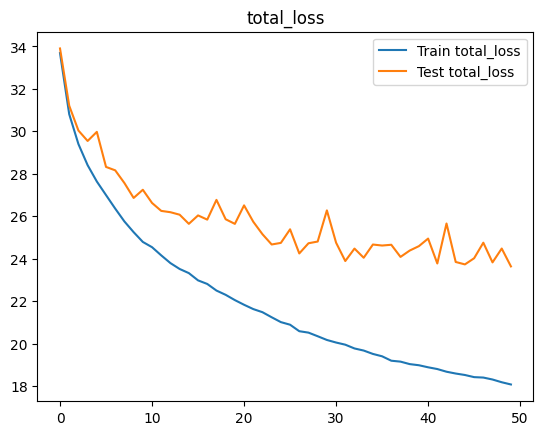

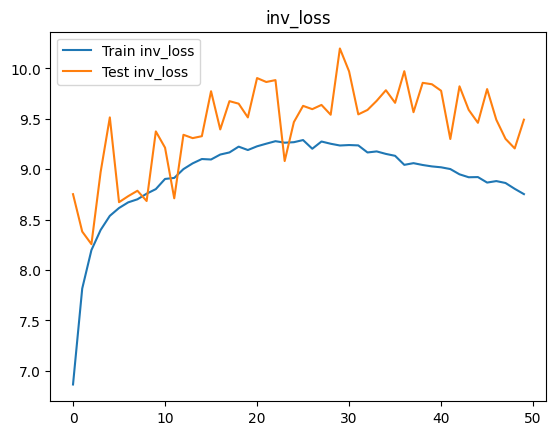

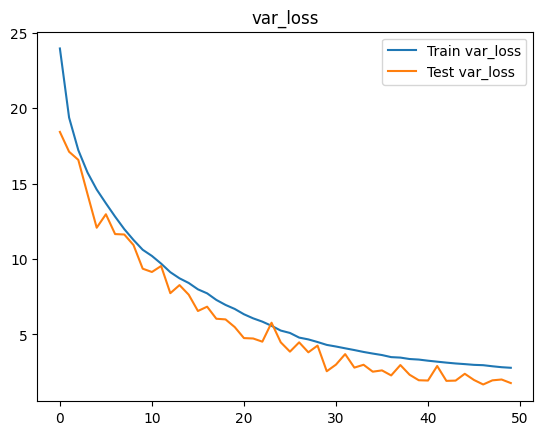

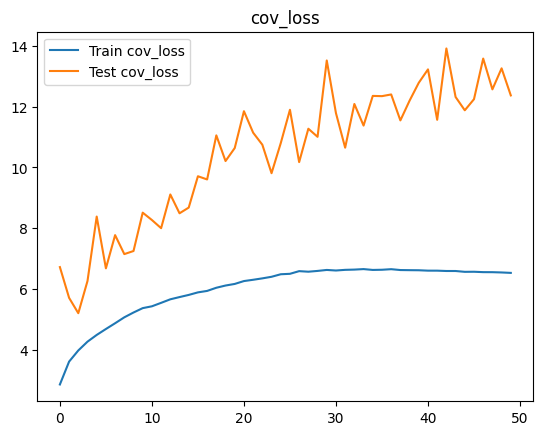

In [20]:
import matplotlib.pyplot as plt
for key in vicreg_train_losses.keys():
    plt.plot(vicreg_train_losses[key], label=('Train ' + key))
    plt.plot(vicreg_test_losses[key], label=('Test ' + key))
    plt.legend()
    plt.title(key)
    plt.show()

# Load Trained Model

In [21]:
trained_model = VicReg(D=128, proj_dim=512, device=device).to(device)
trained_model.load_state_dict(torch.load('/kaggle/working/vicreg_model.pth'))

<All keys matched successfully>

# PCA vs TSNE

In [1]:
def plot_representations(data, labels, title):
    cifar10_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.set_ticklabels(cifar10_classes)
    cbar.set_label('Classes')
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

repr_test_set = datasets.CIFAR10(root='/kaggle/input/cifer-10', train=False, download=False, transform=test_transform)
repr_test_loader = DataLoader(repr_test_set, batch_size=256, shuffle=False, num_workers=2)

representations = []
labels = []

with torch.no_grad():
    for images, targets in tqdm(repr_test_loader, desc="Computing representations"):
        images = images.to(device)
        batch_representations = trained_model.encoder.encode(images)
        representations.append(batch_representations.cpu().numpy())
        labels.append(targets.numpy())

representations = np.concatenate(representations)
labels = np.concatenate(labels)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(representations)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(representations)

Computing representations:   0%|          | 0/40 [00:00<?, ?it/s]

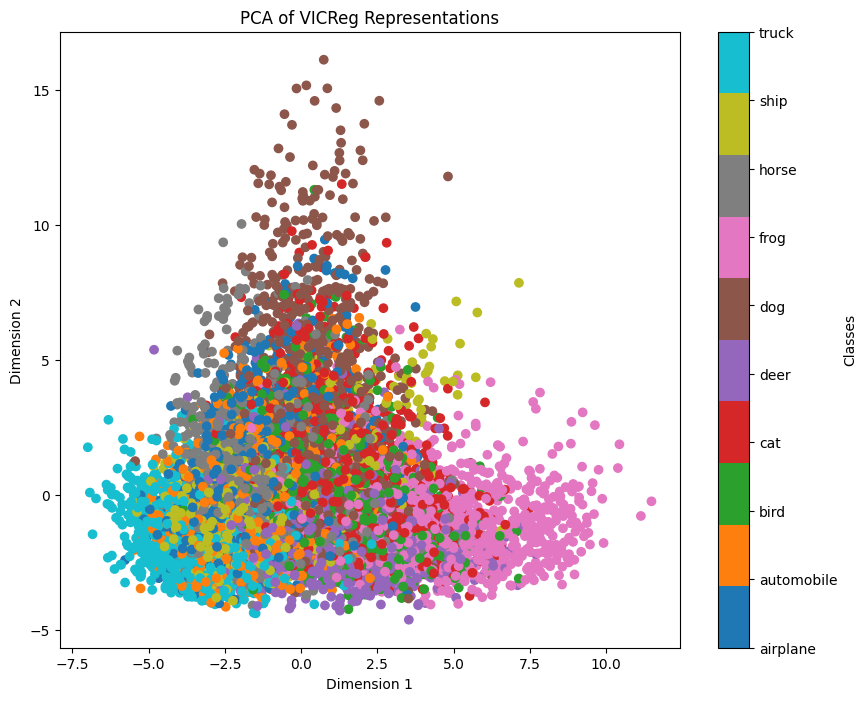

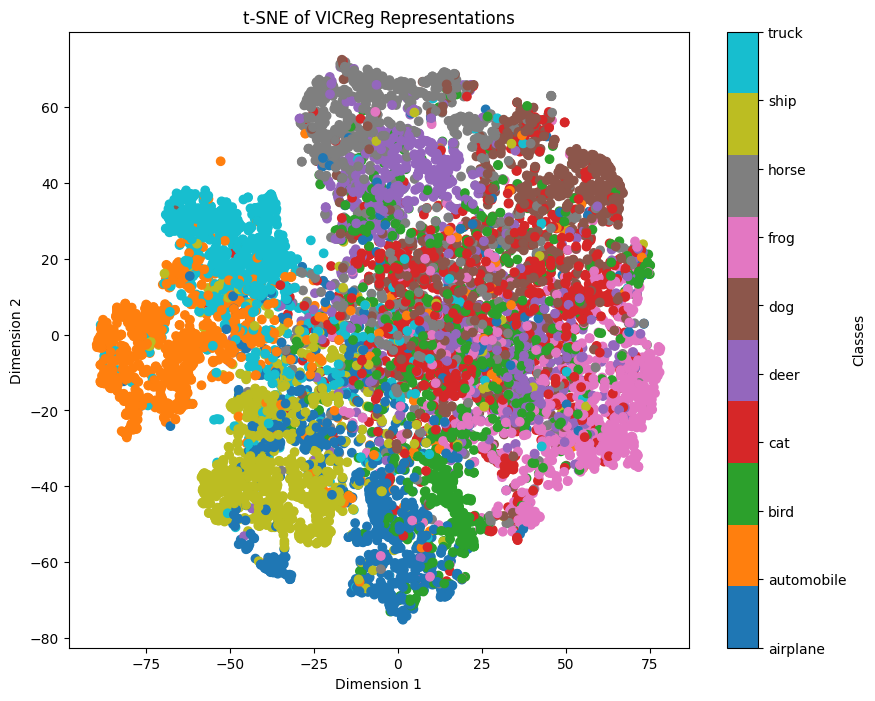

In [4]:
plot_representations(pca_result, labels, 'PCA of VICReg Representations')

plot_representations(tsne_result, labels, 't-SNE of VICReg Representations')

# Linear Probing

In [22]:
class LinearProbe(nn.Module):
    def __init__(self, encoder, D=128, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(D, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder.encode(x)
        return self.fc(features)

In [1]:
probing_train_set = datasets.CIFAR10(root='/kaggle/input/cifer-10', train=True, download=False, transform=test_transform)
probing_test_set = datasets.CIFAR10(root='/kaggle/input/cifer-10', train=False, download=False, transform=test_transform)
probing_train_loader = DataLoader(probing_train_set, batch_size=256, shuffle=True, num_workers=2)
probing_test_loader = DataLoader(probing_test_set, batch_size=256, shuffle=False, num_workers=2)

linear_probing_model = LinearProbe(trained_model.encoder, D=128, num_classes=10).to(device)
# Freeze the encoder
for param in linear_probing_model.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(linear_probing_model.fc.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

linear_probing_train_losses = []
linear_probing_test_losses = []

for epoch in tqdm(range(1, 31), desc="Linear Probing Training Progress"):
    linear_probing_model.train()
    ep_train_loss = []
    for i, (img, target) in tqdm(enumerate(probing_train_loader), desc="Linear Probing Train Epoch Progress", total=len(probing_train_loader), leave=False ,position=0):
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()
        output = linear_probing_model(img)
        loss = criterion(output, target)
        ep_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss = np.mean(ep_train_loss)
    linear_probing_train_losses.append(train_loss)
    tqdm.write(f'Epoch {epoch}/30 Train Loss: {train_loss}')

    ep_test_loss = []
    ep_test_acc = 0
    linear_probing_model.eval()
    with torch.no_grad():
        for i, (img, target) in tqdm(enumerate(probing_test_loader), desc="Linear Probing Test Epoch Progress", total=len(probing_test_loader), leave=False):
            img, target = img.to(device), target.to(device)
            output = linear_probing_model(img)
            loss = criterion(output, target)
            preds = output.argmax(dim=1)
            correct_preds = (preds == target).sum().item()
            ep_test_acc += correct_preds
            ep_test_loss.append(loss.item())

    test_loss = np.mean(ep_test_loss)
    linear_probing_test_losses.append(test_loss)
    tqdm.write(f'Epoch {epoch}/30 Test Loss: {test_loss}')
    tqdm.write(f'Epoch {epoch}/30 Test Accuracy: {ep_test_acc/len(probing_test_set)}')

linear_probing_model.eval()
torch.save(linear_probing_model.state_dict(), 'linear_probe_model.pth')


Linear Probing Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 1.6673213717888813


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10 Test Loss: 1.1747224807739258
Epoch 1/10 Test Accuracy: 0.6946


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 1.0136577538689788


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10 Test Loss: 0.9052591323852539
Epoch 2/10 Test Accuracy: 0.7223


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.8519006265061242


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10 Test Loss: 0.8152803093194961
Epoch 3/10 Test Accuracy: 0.7368


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.786356908022141


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10 Test Loss: 0.771073441207409
Epoch 4/10 Test Accuracy: 0.7422


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.7520971486763078


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10 Test Loss: 0.7449420616030693
Epoch 5/10 Test Accuracy: 0.7459


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.7295149960079972


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10 Test Loss: 0.7295950599014759
Epoch 6/10 Test Accuracy: 0.7464


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.7145954753671374


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10 Test Loss: 0.7161774307489395
Epoch 7/10 Test Accuracy: 0.7522


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.7046927122437224


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10 Test Loss: 0.7068288914859295
Epoch 8/10 Test Accuracy: 0.7535


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.6947884450153429


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10 Test Loss: 0.6999785013496875
Epoch 9/10 Test Accuracy: 0.7556


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.6870637846236326


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10 Test Loss: 0.694826678186655
Epoch 10/10 Test Accuracy: 0.7552


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/10 Train Loss: 0.6832354372861434


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/10 Test Loss: 0.6906326517462731
Epoch 11/10 Test Accuracy: 0.7572


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/10 Train Loss: 0.6778637867192833


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/10 Test Loss: 0.6853565268218518
Epoch 12/10 Test Accuracy: 0.76


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/10 Train Loss: 0.6736878874350567


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/10 Test Loss: 0.6823157928884029
Epoch 13/10 Test Accuracy: 0.7595


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/10 Train Loss: 0.6697486462641735


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/10 Test Loss: 0.6794478207826614
Epoch 14/10 Test Accuracy: 0.7607


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/10 Train Loss: 0.6676008442834932


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/10 Test Loss: 0.6778480730950832
Epoch 15/10 Test Accuracy: 0.7598


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/10 Train Loss: 0.6661871321955506


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/10 Test Loss: 0.6757055059075355
Epoch 16/10 Test Accuracy: 0.759


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/10 Train Loss: 0.6638425214558231


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/10 Test Loss: 0.673792652785778
Epoch 17/10 Test Accuracy: 0.7612


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/10 Train Loss: 0.6613943905246501


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/10 Test Loss: 0.6714617237448692
Epoch 18/10 Test Accuracy: 0.7619


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/10 Train Loss: 0.6585976974088319


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/10 Test Loss: 0.6706524088978767
Epoch 19/10 Test Accuracy: 0.7602


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/10 Train Loss: 0.6573714407122865


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/10 Test Loss: 0.6694862127304078
Epoch 20/10 Test Accuracy: 0.763


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/10 Train Loss: 0.6569072330484584


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/10 Test Loss: 0.670410543680191
Epoch 21/10 Test Accuracy: 0.7609


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/10 Train Loss: 0.6557932283197131


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/10 Test Loss: 0.6670250259339809
Epoch 22/10 Test Accuracy: 0.763


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/10 Train Loss: 0.6536791041797522


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/10 Test Loss: 0.666925672441721
Epoch 23/10 Test Accuracy: 0.7639


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/10 Train Loss: 0.6551720715907156


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/10 Test Loss: 0.6649394005537033
Epoch 24/10 Test Accuracy: 0.7654


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/10 Train Loss: 0.6516159712051859


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/10 Test Loss: 0.6644197292625904
Epoch 25/10 Test Accuracy: 0.7633


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/10 Train Loss: 0.6507422683798537


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/10 Test Loss: 0.6647874787449837
Epoch 26/10 Test Accuracy: 0.7659


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/10 Train Loss: 0.6487264809559803


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/10 Test Loss: 0.6621105298399925
Epoch 27/10 Test Accuracy: 0.7659


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/10 Train Loss: 0.6480076699232569


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/10 Test Loss: 0.6631251364946366
Epoch 28/10 Test Accuracy: 0.7625


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/10 Train Loss: 0.6484161560632744


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/10 Test Loss: 0.6632470950484276
Epoch 29/10 Test Accuracy: 0.7627


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/10 Train Loss: 0.6479779080468782


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/10 Test Loss: 0.6629124253988266
Epoch 30/10 Test Accuracy: 0.7638


# Q4 - Var Ablation

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_set = AugmentationsDataset(root='/kaggle/input/cifer-10', train=True, transform=train_transform, download=False)
test_set = AugmentationsDataset(root='/kaggle/input/cifer-10', train=False, transform=train_transform, download=False)
var_ablated_model, var_ablated_train_losses, var_ablated_test_losses = train_vicreg(train_set, test_set, batch_size=256, epochs=50, lr=(3*1e-4), device='cuda', mu=0, title='var_ablated_')

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/50 Loss: 0.19095213276367368,Invariant Loss: 0.1730244250478679, Variance Loss: 0.0, Covariance Loss: 0.01792770773149847


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.002749818505253643, Invariant Loss: 0.002749511500587687, Variance Loss: 0.0, Covariance Loss: 3.0699320987537246e-07


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/50 Loss: 0.002119615753608927,Invariant Loss: 0.0021194655772498144, Variance Loss: 0.0, Covariance Loss: 1.5017040259827608e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.001092915290792007, Invariant Loss: 0.0010928710107691586, Variance Loss: 0.0, Covariance Loss: 4.427707944731907e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/50 Loss: 0.0011207812132518168,Invariant Loss: 0.0011207321192475263, Variance Loss: 0.0, Covariance Loss: 4.909285879404836e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0006669578986475244, Invariant Loss: 0.0006669375266938005, Variance Loss: 0.0, Covariance Loss: 2.0375777831649345e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/50 Loss: 0.0006937220441985267,Invariant Loss: 0.0006937048132460071, Variance Loss: 0.0, Covariance Loss: 1.7231157234625186e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00045512005017371847, Invariant Loss: 0.00045511257558246144, Variance Loss: 0.0, Covariance Loss: 7.476860547361852e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/50 Loss: 0.0005046599606950102,Invariant Loss: 0.0005046507525994272, Variance Loss: 0.0, Covariance Loss: 9.207024954230031e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00034422517455823254, Invariant Loss: 0.0003442158424149966, Variance Loss: 0.0, Covariance Loss: 9.334949480077626e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/50 Loss: 0.00038454030184265303,Invariant Loss: 0.00038453450349839024, Variance Loss: 0.0, Covariance Loss: 5.799016971268138e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0003585620885132812, Invariant Loss: 0.00035854311208822766, Variance Loss: 0.0, Covariance Loss: 1.8977993132551773e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/50 Loss: 0.00032931841247327797,Invariant Loss: 0.0003293112366714477, Variance Loss: 0.0, Covariance Loss: 7.175757698924998e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0002291710787176271, Invariant Loss: 0.00022916703092050738, Variance Loss: 0.0, Covariance Loss: 4.048040332105262e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/50 Loss: 0.0002554232298874068,Invariant Loss: 0.00025541879378059614, Variance Loss: 0.0, Covariance Loss: 4.435982611567988e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00017852778582891916, Invariant Loss: 0.00017852539785963019, Variance Loss: 0.0, Covariance Loss: 2.3881558459948325e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/50 Loss: 0.00021049623256305718,Invariant Loss: 0.0002104930154390025, Variance Loss: 0.0, Covariance Loss: 3.216735095410609e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00013204624883655924, Invariant Loss: 0.00013204478527768516, Variance Loss: 0.0, Covariance Loss: 1.464714123253219e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/50 Loss: 0.00017748808223048547,Invariant Loss: 0.00017748565877976645, Variance Loss: 0.0, Covariance Loss: 2.423154838347056e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00016399508203903678, Invariant Loss: 0.00016398946463596075, Variance Loss: 0.0, Covariance Loss: 5.6176281904019024e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/50 Loss: 0.00016041521737452985,Invariant Loss: 0.00016041262457218514, Variance Loss: 0.0, Covariance Loss: 2.5931516999601307e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00012780212691723136, Invariant Loss: 0.00012779838161804946, Variance Loss: 0.0, Covariance Loss: 3.744866203247988e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/50 Loss: 0.00013585304897824986,Invariant Loss: 0.00013585127947278255, Variance Loss: 0.0, Covariance Loss: 1.7696284012987883e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00010190071661781985, Invariant Loss: 0.0001018979717628099, Variance Loss: 0.0, Covariance Loss: 2.744779875607506e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/50 Loss: 0.00012456302654903324,Invariant Loss: 0.0001245606907439057, Variance Loss: 0.0, Covariance Loss: 2.3357903126567223e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 9.8642826469586e-05, Invariant Loss: 9.864067924354458e-05, Variance Loss: 0.0, Covariance Loss: 2.147931345286569e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/50 Loss: 0.00014171051410886897,Invariant Loss: 0.00014170517103166832, Variance Loss: 0.0, Covariance Loss: 5.342564943590792e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 9.576318625477142e-05, Invariant Loss: 9.576096063028672e-05, Variance Loss: 0.0, Covariance Loss: 2.2253478880809864e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/50 Loss: 0.00014966309700699938,Invariant Loss: 0.00014965426475546152, Variance Loss: 0.0, Covariance Loss: 8.832406985922855e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0003819249621301424, Invariant Loss: 0.0003817944321781397, Variance Loss: 0.0, Covariance Loss: 1.3052896912224555e-07


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/50 Loss: 0.00027519975738330836,Invariant Loss: 0.0002751238890800314, Variance Loss: 0.0, Covariance Loss: 7.586804533419946e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0002807110293360893, Invariant Loss: 0.0002806296060043678, Variance Loss: 0.0, Covariance Loss: 8.142480318953927e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/50 Loss: 0.00012073129196045445,Invariant Loss: 0.00012072449432280893, Variance Loss: 0.0, Covariance Loss: 6.797835954784983e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 5.576222665695241e-05, Invariant Loss: 5.5761445037205706e-05, Variance Loss: 0.0, Covariance Loss: 7.81376095510683e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/50 Loss: 8.271518226490802e-05,Invariant Loss: 8.271325135197281e-05, Variance Loss: 0.0, Covariance Loss: 1.9309213162993725e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 9.0266361439717e-05, Invariant Loss: 9.026213538163575e-05, Variance Loss: 0.0, Covariance Loss: 4.226410432045524e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/50 Loss: 0.0002572610210336279,Invariant Loss: 0.000257156531229064, Variance Loss: 0.0, Covariance Loss: 1.0448989127004429e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00030309304311231243, Invariant Loss: 0.00030299158788693603, Variance Loss: 0.0, Covariance Loss: 1.0145625155555393e-07


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/50 Loss: 9.670349587692299e-05,Invariant Loss: 9.66960787991411e-05, Variance Loss: 0.0, Covariance Loss: 7.417405355104283e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 4.148131379224651e-05, Invariant Loss: 4.1481017842670556e-05, Variance Loss: 0.0, Covariance Loss: 2.9556227500171507e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/50 Loss: 0.00014480837716273156,Invariant Loss: 0.00014476990624216898, Variance Loss: 0.0, Covariance Loss: 3.847034822497343e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 4.588972501551325e-05, Invariant Loss: 4.588914703163027e-05, Variance Loss: 0.0, Covariance Loss: 5.778707614853551e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/50 Loss: 9.50624584108983e-05,Invariant Loss: 9.505718991226322e-05, Variance Loss: 0.0, Covariance Loss: 5.268466280940046e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 8.502448499712046e-05, Invariant Loss: 8.501930769853062e-05, Variance Loss: 0.0, Covariance Loss: 5.177545522871973e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/50 Loss: 0.0001978908214777202,Invariant Loss: 0.00019780190908078314, Variance Loss: 0.0, Covariance Loss: 8.891366054431765e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 3.238663971387723e-05, Invariant Loss: 3.238639301343938e-05, Variance Loss: 0.0, Covariance Loss: 2.467603254542594e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/50 Loss: 0.00011597862432646086,Invariant Loss: 0.00011596198673570903, Variance Loss: 0.0, Covariance Loss: 1.663818985045984e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 6.565187109117688e-05, Invariant Loss: 6.564902091668045e-05, Variance Loss: 0.0, Covariance Loss: 2.8500369057826712e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/50 Loss: 0.0005904291400077695,Invariant Loss: 0.0005892261852954552, Variance Loss: 0.0, Covariance Loss: 1.202953951973996e-06


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00014639474320574664, Invariant Loss: 0.0001463723870983813, Variance Loss: 0.0, Covariance Loss: 2.2356109258270252e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/50 Loss: 4.2384031707003985e-05,Invariant Loss: 4.238334416613168e-05, Variance Loss: 0.0, Covariance Loss: 6.875604963492291e-10


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00020929347829223843, Invariant Loss: 0.0002092378670567996, Variance Loss: 0.0, Covariance Loss: 5.561061532932676e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/50 Loss: 5.667258870298796e-05,Invariant Loss: 5.6670354770547566e-05, Variance Loss: 0.0, Covariance Loss: 2.234009624824798e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 7.780489713695715e-05, Invariant Loss: 7.779905326970038e-05, Variance Loss: 0.0, Covariance Loss: 5.843337683164585e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/50 Loss: 0.00020658329743369273,Invariant Loss: 0.00020649701001479562, Variance Loss: 0.0, Covariance Loss: 8.628763129080443e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 4.8872021352508455e-05, Invariant Loss: 4.887023465016682e-05, Variance Loss: 0.0, Covariance Loss: 1.7866298933355562e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/50 Loss: 4.6477627611053245e-05,Invariant Loss: 4.6476271605495974e-05, Variance Loss: 0.0, Covariance Loss: 1.3560226836230258e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 5.711428848371724e-05, Invariant Loss: 5.711212925234577e-05, Variance Loss: 0.0, Covariance Loss: 2.159044790173148e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/50 Loss: 5.465415338500063e-05,Invariant Loss: 5.464977017737158e-05, Variance Loss: 0.0, Covariance Loss: 4.383246780311983e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 3.636161613940203e-05, Invariant Loss: 3.63607251074427e-05, Variance Loss: 0.0, Covariance Loss: 8.911851517162672e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31/50 Loss: 8.079804678698342e-05,Invariant Loss: 8.078879371317513e-05, Variance Loss: 0.0, Covariance Loss: 9.253273357792068e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00012853323687522789, Invariant Loss: 0.00012850296479882672, Variance Loss: 0.0, Covariance Loss: 3.027234017904945e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32/50 Loss: 0.0002907742846311558,Invariant Loss: 0.0002904356040985755, Variance Loss: 0.0, Covariance Loss: 3.386789134228831e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 8.96339116479794e-05, Invariant Loss: 8.962374113252736e-05, Variance Loss: 0.0, Covariance Loss: 1.0171127903801924e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33/50 Loss: 0.00017982070438643413,Invariant Loss: 0.00017973509278706434, Variance Loss: 0.0, Covariance Loss: 8.561123844875299e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 2.4558131030971708e-05, Invariant Loss: 2.455779733736563e-05, Variance Loss: 0.0, Covariance Loss: 3.337286690052732e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34/50 Loss: 7.11118766688816e-05,Invariant Loss: 7.110034906483114e-05, Variance Loss: 0.0, Covariance Loss: 1.1527792454505448e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 3.284142885604524e-05, Invariant Loss: 3.284078593424056e-05, Variance Loss: 0.0, Covariance Loss: 6.429921605571876e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35/50 Loss: 8.718589545572528e-05,Invariant Loss: 8.717063274718608e-05, Variance Loss: 0.0, Covariance Loss: 1.5262727240862214e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 5.7532150879069374e-05, Invariant Loss: 5.752895489194998e-05, Variance Loss: 0.0, Covariance Loss: 3.1961709747591048e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36/50 Loss: 0.00013537523135691656,Invariant Loss: 0.0001353291076973582, Variance Loss: 0.0, Covariance Loss: 4.6123304456571583e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00015048573304738967, Invariant Loss: 0.0001504592761193635, Variance Loss: 0.0, Covariance Loss: 2.645614530782936e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37/50 Loss: 7.762253142350439e-05,Invariant Loss: 7.761216102153412e-05, Variance Loss: 0.0, Covariance Loss: 1.0370490332125151e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0001940038915563491, Invariant Loss: 0.0001939481201588933, Variance Loss: 0.0, Covariance Loss: 5.5769650475490094e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38/50 Loss: 0.00046151594447759896,Invariant Loss: 0.00046077404177984657, Variance Loss: 0.0, Covariance Loss: 7.419023005392381e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 4.6884542189218334e-05, Invariant Loss: 4.688223875746189e-05, Variance Loss: 0.0, Covariance Loss: 2.3034840733633653e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39/50 Loss: 0.00013158353742571252,Invariant Loss: 0.00013149424498991796, Variance Loss: 0.0, Covariance Loss: 8.929304946878897e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0033653653459623455, Invariant Loss: 0.0033456516976002604, Variance Loss: 0.0, Covariance Loss: 1.971364192456804e-05


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40/50 Loss: 0.0001494816741732003,Invariant Loss: 0.0001492796144266693, Variance Loss: 0.0, Covariance Loss: 2.0206076255185884e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 3.443736204644665e-05, Invariant Loss: 3.443560431151127e-05, Variance Loss: 0.0, Covariance Loss: 1.757808298918917e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41/50 Loss: 0.0001421027499655069,Invariant Loss: 0.00014202580407109795, Variance Loss: 0.0, Covariance Loss: 7.694571009783728e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0001590673529790365, Invariant Loss: 0.00015904195643088315, Variance Loss: 0.0, Covariance Loss: 2.539713360727447e-08


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42/50 Loss: 6.948151803953806e-05,Invariant Loss: 6.946830065001505e-05, Variance Loss: 0.0, Covariance Loss: 1.3217274530556909e-08


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 8.932947008588598e-06, Invariant Loss: 8.93289647478923e-06, Variance Loss: 0.0, Covariance Loss: 5.05463193436334e-11


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43/50 Loss: 2.483265341058485e-05,Invariant Loss: 2.483163652590408e-05, Variance Loss: 0.0, Covariance Loss: 1.0168714302779366e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.2851808571667789e-05, Invariant Loss: 1.2851623000642576e-05, Variance Loss: 0.0, Covariance Loss: 1.8563492860945717e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44/50 Loss: 1.0517981659362779e-05,Invariant Loss: 1.0517881877121351e-05, Variance Loss: 0.0, Covariance Loss: 9.976141288705555e-11


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 2.691519600830361e-05, Invariant Loss: 2.6913936926575845e-05, Variance Loss: 0.0, Covariance Loss: 1.25900468800344e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45/50 Loss: 0.00014723958303402098,Invariant Loss: 0.00014706722149361557, Variance Loss: 0.0, Covariance Loss: 1.723617234642042e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0004129788365389686, Invariant Loss: 0.00041273867682320995, Variance Loss: 0.0, Covariance Loss: 2.40160796316502e-07


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46/50 Loss: 0.0003657644213638619,Invariant Loss: 0.0003646375684907906, Variance Loss: 0.0, Covariance Loss: 1.126851871778578e-06


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0020164914065389896, Invariant Loss: 0.002008433439186774, Variance Loss: 0.0, Covariance Loss: 8.05798459282414e-06


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47/50 Loss: 0.00028932996298065014,Invariant Loss: 0.0002891060750967807, Variance Loss: 0.0, Covariance Loss: 2.2388665416801053e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 3.9286071887545405e-05, Invariant Loss: 3.92835873981312e-05, Variance Loss: 0.0, Covariance Loss: 2.4844950242963736e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48/50 Loss: 5.383800961848168e-05,Invariant Loss: 5.383027289971491e-05, Variance Loss: 0.0, Covariance Loss: 7.736595483540775e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 5.00935436321015e-05, Invariant Loss: 5.00895712775673e-05, Variance Loss: 0.0, Covariance Loss: 3.9722742678494075e-09


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49/50 Loss: 0.0001836029708296597,Invariant Loss: 0.0001834992345924993, Variance Loss: 0.0, Covariance Loss: 1.0373669693335396e-07


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.4486096961263684e-05, Invariant Loss: 1.4485910469375085e-05, Variance Loss: 0.0, Covariance Loss: 1.8647331291934965e-10


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50/50 Loss: 2.0546551869598742e-05,Invariant Loss: 2.0544370272546075e-05, Variance Loss: 0.0, Covariance Loss: 2.1815521632399443e-09


Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.00032077036794362355, Invariant Loss: 0.0003205805984180188, Variance Loss: 0.0, Covariance Loss: 1.8977011908560826e-07


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Computing representations:   0%|          | 0/40 [00:00<?, ?it/s]

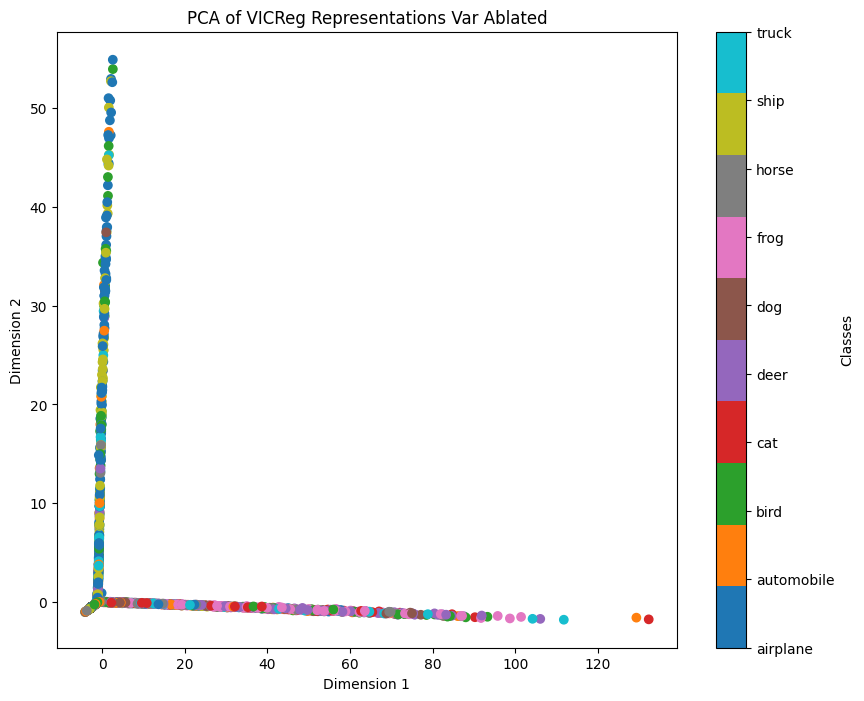

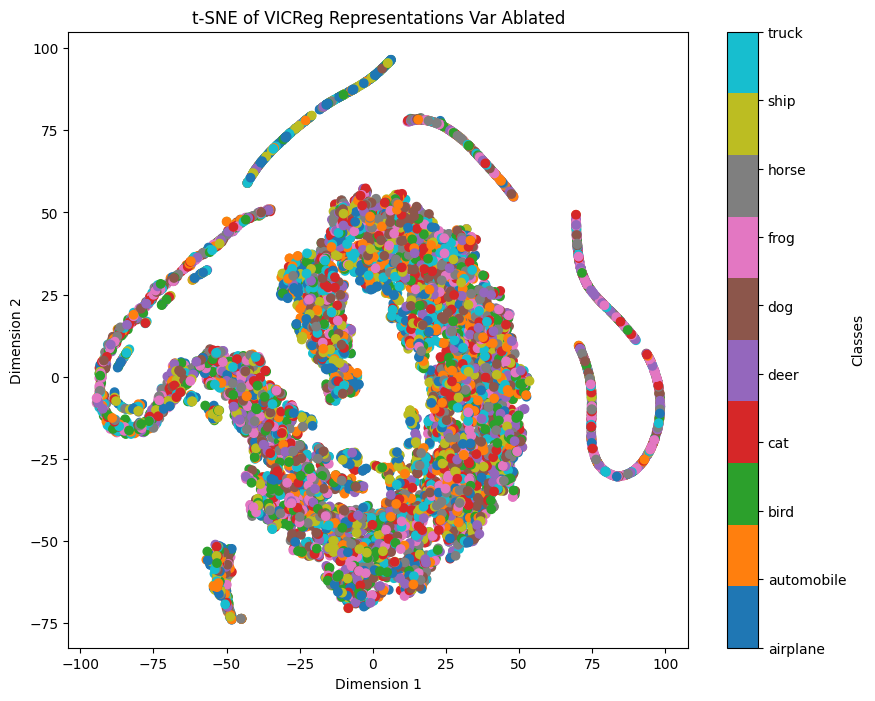

In [1]:
trained_var_ablated_model = VicReg(D=128, proj_dim=512, device=device).to(device)
trained_var_ablated_model.load_state_dict(torch.load('/kaggle/working/var_ablated_vicreg_model.pth'))
var_ablated_representations = []
var_ablated_labels = []

with torch.no_grad():
    for images, targets in tqdm(repr_test_loader, desc="Computing representations"):
        images = images.to(device)
        batch_representations = trained_var_ablated_model.encoder.encode(images)
        var_ablated_representations.append(batch_representations.cpu().numpy())
        var_ablated_labels.append(targets.numpy())

var_ablated_representations = np.concatenate(var_ablated_representations)
var_ablated_labels = np.concatenate(var_ablated_labels)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(var_ablated_representations)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(var_ablated_representations)
plot_representations(pca_result, var_ablated_labels, 'PCA of VICReg Representations Var Ablated')
plot_representations(tsne_result, var_ablated_labels, 't-SNE of VICReg Representations Var Ablated')

In [1]:
var_ablated_linear_probing_model = LinearProbe(trained_var_ablated_model.encoder, D=128, num_classes=10).to(device)
# Freeze the encoder
for param in var_ablated_linear_probing_model.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(var_ablated_linear_probing_model.fc.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

linear_probing_train_losses = []
linear_probing_test_losses = []

for epoch in tqdm(range(1, 31), desc="Linear Probing Training Progress"):
    var_ablated_linear_probing_model.train()
    ep_train_loss = []
    for i, (img, target) in tqdm(enumerate(probing_train_loader), desc="Linear Probing Train Epoch Progress", total=len(probing_train_loader), leave=False ,position=0):
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()
        output = var_ablated_linear_probing_model(img)
        loss = criterion(output, target)
        ep_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss = np.mean(ep_train_loss)
    linear_probing_train_losses.append(train_loss)
    tqdm.write(f'Epoch {epoch}/30 Train Loss: {train_loss}')

    ep_test_loss = []
    ep_test_acc = 0
    var_ablated_linear_probing_model.eval()
    with torch.no_grad():
        for i, (img, target) in tqdm(enumerate(probing_test_loader), desc="Linear Probing Test Epoch Progress", total=len(probing_test_loader), leave=False):
            img, target = img.to(device), target.to(device)
            output = var_ablated_linear_probing_model(img)
            loss = criterion(output, target)
            preds = output.argmax(dim=1)
            correct_preds = (preds == target).sum().item()
            ep_test_acc += correct_preds
            ep_test_loss.append(loss.item())

    test_loss = np.mean(ep_test_loss)
    linear_probing_test_losses.append(test_loss)
    tqdm.write(f'Epoch {epoch}/30 Test Loss: {test_loss}')
    tqdm.write(f'Epoch {epoch}/30 Test Accuracy: {ep_test_acc/len(probing_test_set)}')

var_ablated_linear_probing_model.eval()
torch.save(var_ablated_linear_probing_model.state_dict(), 'var_ablated_linear_probe_model.pth')


Linear Probing Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 2.273009723546554


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/30 Test Loss: 2.255573660135269
Epoch 1/30 Test Accuracy: 0.1326


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 2.2582509505505466


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/30 Test Loss: 2.2511753261089327
Epoch 2/30 Test Accuracy: 0.1328


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 2.2566071797390372


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/30 Test Loss: 2.249360954761505
Epoch 3/30 Test Accuracy: 0.135


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 2.2560964141573225


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/30 Test Loss: 2.249193048477173
Epoch 4/30 Test Accuracy: 0.1316


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 2.2550797863882415


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/30 Test Loss: 2.2493150532245636
Epoch 5/30 Test Accuracy: 0.1375


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 2.2562892193696937


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/30 Test Loss: 2.2476949214935305
Epoch 6/30 Test Accuracy: 0.1331


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 2.256261857188478


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/30 Test Loss: 2.2486877262592317
Epoch 7/30 Test Accuracy: 0.1349


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 2.255279182171335


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/30 Test Loss: 2.2493296682834627
Epoch 8/30 Test Accuracy: 0.1356


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 2.2548584183868097


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/30 Test Loss: 2.2515212833881377
Epoch 9/30 Test Accuracy: 0.134


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 2.253792789517617


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/30 Test Loss: 2.2464013934135436
Epoch 10/30 Test Accuracy: 0.1362


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/10 Train Loss: 2.254114189926459


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/30 Test Loss: 2.248092848062515
Epoch 11/30 Test Accuracy: 0.1386


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/10 Train Loss: 2.2538286520510304


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/30 Test Loss: 2.2463618516921997
Epoch 12/30 Test Accuracy: 0.1364


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/10 Train Loss: 2.2543072724828916


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/30 Test Loss: 2.245183211565018
Epoch 13/30 Test Accuracy: 0.1381


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/10 Train Loss: 2.2538249419659984


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/30 Test Loss: 2.2438101708889007
Epoch 14/30 Test Accuracy: 0.1405


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/10 Train Loss: 2.253345563703654


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/30 Test Loss: 2.243876796960831
Epoch 15/30 Test Accuracy: 0.1381


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/10 Train Loss: 2.2520187424153697


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/30 Test Loss: 2.247194290161133
Epoch 16/30 Test Accuracy: 0.1374


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/10 Train Loss: 2.252321021897452


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/30 Test Loss: 2.2447286188602447
Epoch 17/30 Test Accuracy: 0.1376


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/10 Train Loss: 2.2529383253078072


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/30 Test Loss: 2.2498034954071047
Epoch 18/30 Test Accuracy: 0.1355


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/10 Train Loss: 2.2511896235602245


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/30 Test Loss: 2.248369801044464
Epoch 19/30 Test Accuracy: 0.1361


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/10 Train Loss: 2.25159711862097


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/30 Test Loss: 2.2472063660621644
Epoch 20/30 Test Accuracy: 0.137


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/10 Train Loss: 2.2519107935379963


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/30 Test Loss: 2.245086747407913
Epoch 21/30 Test Accuracy: 0.1389


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/10 Train Loss: 2.250977500360839


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/30 Test Loss: 2.2433039486408233
Epoch 22/30 Test Accuracy: 0.1395


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/10 Train Loss: 2.2512065050553303


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/30 Test Loss: 2.244055390357971
Epoch 23/30 Test Accuracy: 0.1381


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/10 Train Loss: 2.2509475922097963


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/30 Test Loss: 2.2464310228824615
Epoch 24/30 Test Accuracy: 0.1375


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/10 Train Loss: 2.251688721228619


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/30 Test Loss: 2.2443195104599
Epoch 25/30 Test Accuracy: 0.1395


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/10 Train Loss: 2.2500798239999886


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/30 Test Loss: 2.2450741291046143
Epoch 26/30 Test Accuracy: 0.141


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/10 Train Loss: 2.250537150976609


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/30 Test Loss: 2.2455037236213684
Epoch 27/30 Test Accuracy: 0.138


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/10 Train Loss: 2.2502692487775064


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/30 Test Loss: 2.2454585254192354
Epoch 28/30 Test Accuracy: 0.1382


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/10 Train Loss: 2.2496257764952525


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/30 Test Loss: 2.241135537624359
Epoch 29/30 Test Accuracy: 0.1417


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/10 Train Loss: 2.2500875348947487


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/30 Test Loss: 2.2422303438186644
Epoch 30/30 Test Accuracy: 0.14


# Q5 - Nearest Neighbors

In [1]:
knn_train_set = datasets.CIFAR10(root='/kaggle/input/cifer-10', train=True, download=False, transform=test_transform)
knn_test_set = datasets.CIFAR10(root='/kaggle/input/cifer-10', train=False, download=False, transform=test_transform)
knn_train_loader = DataLoader(knn_train_set, batch_size=256, shuffle=False, num_workers=2)
knn_test_loader = DataLoader(knn_test_set, batch_size=256, shuffle=False, num_workers=2)
trained_vicreg_model = VicReg(D=128, proj_dim=512, device=device).to(device)
trained_vicreg_model.load_state_dict(torch.load('/kaggle/working/vicreg_model.pth'))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [2]:
knn_representations = []
knn_labels = []
trained_vicreg_model.eval()
with torch.no_grad():
    for images, targets in tqdm(knn_train_loader, desc="Computing representations"):
        images = images.to(device)
        batch_representations = trained_vicreg_model.encoder.encode(images)
        knn_representations.append(batch_representations.cpu().numpy())
        knn_labels.append(targets.numpy())
        
knn_representations = np.concatenate(knn_representations)
knn_labels = np.concatenate(knn_labels)

Computing representations:   0%|          | 0/196 [00:00<?, ?it/s]

In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

class NeighborDataset(Dataset):
    def __init__(self, original_dataset, representations, n_neighbors=4):
        self.original_dataset = original_dataset
        self.representations = representations
        
        self.nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
        self.nn.fit(self.representations)
        
        self.neighbors = self.nn.kneighbors(self.representations, return_distance=False)

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img1, label = self.original_dataset[idx]
        neighbor_idx = np.random.choice(self.neighbors[idx][1:])  # Exclude the first neighbor (original image)
        img2, _ = self.original_dataset[neighbor_idx]
        return img1, img2, label

In [1]:
nn_train_set = NeighborDataset(knn_train_set, knn_representations)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nn_model, nn_train_losses, nn_test_losses = train_vicreg(nn_train_set, None, batch_size=256, epochs=50, lr=(3*1e-4), device=device, mu=25, title='nn_')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/50 Loss: 32.122717604345205,Invariant Loss: 5.973967856290389, Variance Loss: 22.451156869226573, Covariance Loss: 3.697592944514995


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/50 Loss: 27.533887434978876,Invariant Loss: 5.926694916219128, Variance Loss: 16.259747383545857, Covariance Loss: 5.347445098721251


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/50 Loss: 25.050660688049938,Invariant Loss: 5.684285655313609, Variance Loss: 13.123178024681247, Covariance Loss: 6.243197020219297


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/50 Loss: 23.143573303611912,Invariant Loss: 5.593234646077058, Variance Loss: 10.644683974129814, Covariance Loss: 6.905654593389862


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/50 Loss: 21.62696409225464,Invariant Loss: 5.477345177105495, Variance Loss: 8.670598723450485, Covariance Loss: 7.479020257385409


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/50 Loss: 20.42141681787919,Invariant Loss: 5.381692562784467, Variance Loss: 7.128870956751765, Covariance Loss: 7.910853276447374


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/50 Loss: 19.49045346707714,Invariant Loss: 5.367301811977309, Variance Loss: 5.902089279525134, Covariance Loss: 8.22106233421637


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/50 Loss: 18.59277716461493,Invariant Loss: 5.34862993201431, Variance Loss: 4.777858892265631, Covariance Loss: 8.466288345200676


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/50 Loss: 17.903273932787837,Invariant Loss: 5.336107375670452, Variance Loss: 4.016322772113645, Covariance Loss: 8.550843764324577


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/50 Loss: 17.260776393267573,Invariant Loss: 5.249709791066695, Variance Loss: 3.47880000484233, Covariance Loss: 8.53226663628403


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/50 Loss: 16.828575523532166,Invariant Loss: 5.270762190526845, Variance Loss: 3.136445394584111, Covariance Loss: 8.42136794693616


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/50 Loss: 16.306421941640426,Invariant Loss: 5.138260432652065, Variance Loss: 2.831730534835738, Covariance Loss: 8.33643094374209


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/50 Loss: 15.858038984999364,Invariant Loss: 5.070965608771966, Variance Loss: 2.5639143543584004, Covariance Loss: 8.22315899693236


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/50 Loss: 15.516890871281527,Invariant Loss: 4.99637444895141, Variance Loss: 2.3935316788906955, Covariance Loss: 8.126984768984268


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/50 Loss: 15.20036877418051,Invariant Loss: 4.944402614418341, Variance Loss: 2.243141312988437, Covariance Loss: 8.012824851639417


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/50 Loss: 14.926197543436167,Invariant Loss: 4.877470825399671, Variance Loss: 2.116780928203038, Covariance Loss: 7.931945805646936


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/50 Loss: 14.690163763201966,Invariant Loss: 4.87527859210968, Variance Loss: 1.9907795227303797, Covariance Loss: 7.824105654444013


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/50 Loss: 14.45394490203079,Invariant Loss: 4.790815139303402, Variance Loss: 1.9152612868620424, Covariance Loss: 7.747868530604304


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/50 Loss: 14.246520412211515,Invariant Loss: 4.773833493797147, Variance Loss: 1.8243739531964671, Covariance Loss: 7.6483129627850595


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/50 Loss: 14.107152510662468,Invariant Loss: 4.752998697514436, Variance Loss: 1.7790865137868999, Covariance Loss: 7.5750673109171345


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/50 Loss: 13.929566062226588,Invariant Loss: 4.732731954175598, Variance Loss: 1.7144400854499973, Covariance Loss: 7.482394050578682


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/50 Loss: 13.765490137800878,Invariant Loss: 4.688823425039953, Variance Loss: 1.6594461585794176, Covariance Loss: 7.417220541409084


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/50 Loss: 13.610370485150085,Invariant Loss: 4.64558064451023, Variance Loss: 1.6100162808992424, Covariance Loss: 7.354773579811563


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/50 Loss: 13.491500723118685,Invariant Loss: 4.628558712346213, Variance Loss: 1.5758902284563805, Covariance Loss: 7.287051757987665


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/50 Loss: 13.392871321464071,Invariant Loss: 4.622923791408539, Variance Loss: 1.5457287543282217, Covariance Loss: 7.22421873345667


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/50 Loss: 13.286886069239403,Invariant Loss: 4.622894122892497, Variance Loss: 1.5008183751179247, Covariance Loss: 7.163173641477313


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/50 Loss: 13.176728452954974,Invariant Loss: 4.6111303154303105, Variance Loss: 1.4568095021710104, Covariance Loss: 7.108788631400284


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/50 Loss: 13.010882416549993,Invariant Loss: 4.544536950636883, Variance Loss: 1.4225663612691724, Covariance Loss: 7.043779103123412


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/50 Loss: 12.926647993983055,Invariant Loss: 4.5312764267532195, Variance Loss: 1.398221565448508, Covariance Loss: 6.997150022156385


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/50 Loss: 12.863456954761427,Invariant Loss: 4.535494591508593, Variance Loss: 1.3838624917730993, Covariance Loss: 6.944099886076791


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31/50 Loss: 12.800912112605815,Invariant Loss: 4.526969278345303, Variance Loss: 1.3716951535672557, Covariance Loss: 6.90224762838714


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32/50 Loss: 12.667512402242544,Invariant Loss: 4.493730122945746, Variance Loss: 1.3319103374164931, Covariance Loss: 6.841871971986731


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33/50 Loss: 12.590759982868116,Invariant Loss: 4.4758023802114995, Variance Loss: 1.3056051205007397, Covariance Loss: 6.809352502530935


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34/50 Loss: 12.557406216251607,Invariant Loss: 4.485817775434377, Variance Loss: 1.3013026030087957, Covariance Loss: 6.770285801011688


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35/50 Loss: 12.503075808894877,Invariant Loss: 4.504619748008494, Variance Loss: 1.2856373571011486, Covariance Loss: 6.712818736932715


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36/50 Loss: 12.39012668084125,Invariant Loss: 4.46335320570031, Variance Loss: 1.241994549729386, Covariance Loss: 6.6847788825327035


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37/50 Loss: 12.345858948571342,Invariant Loss: 4.4795005029561565, Variance Loss: 1.2370014774556062, Covariance Loss: 6.629356953562523


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38/50 Loss: 12.209102971213204,Invariant Loss: 4.385437820638929, Variance Loss: 1.218764499133947, Covariance Loss: 6.604900652048539


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39/50 Loss: 12.233197192756498,Invariant Loss: 4.445830901058352, Variance Loss: 1.228435950011623, Covariance Loss: 6.558930333779783


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40/50 Loss: 12.103954397902196,Invariant Loss: 4.403287205160881, Variance Loss: 1.1784023672950512, Covariance Loss: 6.522264828487319


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41/50 Loss: 12.07541653088161,Invariant Loss: 4.390675661515217, Variance Loss: 1.1805155719725453, Covariance Loss: 6.504225271088736


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42/50 Loss: 12.05026600798782,Invariant Loss: 4.40453813513931, Variance Loss: 1.1765529102816874, Covariance Loss: 6.469174949490294


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43/50 Loss: 12.01383019953358,Invariant Loss: 4.4093517052884, Variance Loss: 1.1582185221569878, Covariance Loss: 6.446260019224518


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44/50 Loss: 11.958570485212364,Invariant Loss: 4.403758888341943, Variance Loss: 1.1403186604076503, Covariance Loss: 6.414492998804365


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45/50 Loss: 11.881464627324318,Invariant Loss: 4.380086901236553, Variance Loss: 1.124567645849014, Covariance Loss: 6.376810083583909


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46/50 Loss: 11.786306984570562,Invariant Loss: 4.333755231633479, Variance Loss: 1.1191035256702073, Covariance Loss: 6.333448225138139


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47/50 Loss: 11.832154629181842,Invariant Loss: 4.389427652164382, Variance Loss: 1.116147342385078, Covariance Loss: 6.326579597531532


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48/50 Loss: 11.72958779335022,Invariant Loss: 4.338120503085, Variance Loss: 1.0961667043822152, Covariance Loss: 6.2953005785844764


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49/50 Loss: 11.743702270546738,Invariant Loss: 4.356027822105252, Variance Loss: 1.103965228613542, Covariance Loss: 6.283709163568457


Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50/50 Loss: 11.650206463677543,Invariant Loss: 4.325690729277475, Variance Loss: 1.0796801675947345, Covariance Loss: 6.244835566501228


In [1]:
nn_model = VicReg(D=128, proj_dim=512, device=device).to(device)
nn_model.load_state_dict(torch.load('/kaggle/working/nn_vicreg_model.pth'))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [2]:
nn_linear_probing_model = LinearProbe(nn_model.encoder, D=128, num_classes=10).to(device)
# Freeze the encoder
for param in nn_linear_probing_model.encoder.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(nn_linear_probing_model.fc.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

linear_probing_train_losses = []
linear_probing_test_losses = []

for epoch in tqdm(range(1, 31), desc="Linear Probing Training Progress"):
    nn_linear_probing_model.train()
    ep_train_loss = []
    for i, (img, target) in tqdm(enumerate(probing_train_loader), desc="Linear Probing Train Epoch Progress", total=len(probing_train_loader), leave=False ,position=0):
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()
        output = nn_linear_probing_model(img)
        loss = criterion(output, target)
        ep_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss = np.mean(ep_train_loss)
    linear_probing_train_losses.append(train_loss)
    tqdm.write(f'Epoch {epoch}/30 Train Loss: {train_loss}')

    ep_test_loss = []
    ep_test_acc = 0
    nn_linear_probing_model.eval()
    with torch.no_grad():
        for i, (img, target) in tqdm(enumerate(probing_test_loader), desc="Linear Probing Test Epoch Progress", total=len(probing_test_loader), leave=False):
            img, target = img.to(device), target.to(device)
            output = nn_linear_probing_model(img)
            loss = criterion(output, target)
            preds = output.argmax(dim=1)
            correct_preds = (preds == target).sum().item()
            ep_test_acc += correct_preds
            ep_test_loss.append(loss.item())

    test_loss = np.mean(ep_test_loss)
    linear_probing_test_losses.append(test_loss)
    tqdm.write(f'Epoch {epoch}/30 Test Loss: {test_loss}')
    tqdm.write(f'Epoch {epoch}/30 Test Accuracy: {ep_test_acc/len(probing_test_set)}')

nn_linear_probing_model.eval()
torch.save(nn_linear_probing_model.state_dict(), 'nn_linear_probe_model.pth')


Linear Probing Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1/30 Train Loss: 1.8224973465715135


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/30 Test Loss: 1.4058095216751099
Epoch 1/30 Test Accuracy: 0.6741


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2/30 Train Loss: 1.1664191238125976


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/30 Test Loss: 1.0605452001094817
Epoch 2/30 Test Accuracy: 0.7103


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3/30 Train Loss: 0.9505877756342596


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/30 Test Loss: 0.9316043496131897
Epoch 3/30 Test Accuracy: 0.7211


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4/30 Train Loss: 0.8663017004728317


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/30 Test Loss: 0.8711857303977013
Epoch 4/30 Test Accuracy: 0.7276


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5/30 Train Loss: 0.824445897827343


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/30 Test Loss: 0.8384839043021202
Epoch 5/30 Test Accuracy: 0.7285


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6/30 Train Loss: 0.7999562140630216


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/30 Test Loss: 0.8209970027208329
Epoch 6/30 Test Accuracy: 0.73


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7/30 Train Loss: 0.7841691292670309


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/30 Test Loss: 0.8067887514829636
Epoch 7/30 Test Accuracy: 0.7322


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8/30 Train Loss: 0.7736648719529716


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/30 Test Loss: 0.7987099781632423
Epoch 8/30 Test Accuracy: 0.7315


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9/30 Train Loss: 0.7654652692833726


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/30 Test Loss: 0.7905864328145981
Epoch 9/30 Test Accuracy: 0.7326


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10/30 Train Loss: 0.758831264413133


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/30 Test Loss: 0.783347487449646
Epoch 10/30 Test Accuracy: 0.736


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11/30 Train Loss: 0.7554781293990661


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/30 Test Loss: 0.7780540302395821
Epoch 11/30 Test Accuracy: 0.7366


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12/30 Train Loss: 0.7516934637512479


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/30 Test Loss: 0.7744017228484154
Epoch 12/30 Test Accuracy: 0.7374


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13/30 Train Loss: 0.7470850746850578


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/30 Test Loss: 0.7713464424014091
Epoch 13/30 Test Accuracy: 0.7357


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14/30 Train Loss: 0.7456330660046363


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/30 Test Loss: 0.7693636283278465
Epoch 14/30 Test Accuracy: 0.7366


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15/30 Train Loss: 0.7438176791278683


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/30 Test Loss: 0.7663194105029106
Epoch 15/30 Test Accuracy: 0.7389


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16/30 Train Loss: 0.7402299934503983


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/30 Test Loss: 0.7648930087685585
Epoch 16/30 Test Accuracy: 0.74


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17/30 Train Loss: 0.7390230662968694


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/30 Test Loss: 0.7614233002066613
Epoch 17/30 Test Accuracy: 0.7406


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18/30 Train Loss: 0.7352907304861107


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/30 Test Loss: 0.7612426117062568
Epoch 18/30 Test Accuracy: 0.7407


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19/30 Train Loss: 0.7350076887072349


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/30 Test Loss: 0.7578134998679161
Epoch 19/30 Test Accuracy: 0.7403


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20/30 Train Loss: 0.7335038252022802


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/30 Test Loss: 0.7576778784394265
Epoch 20/30 Test Accuracy: 0.7408


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21/30 Train Loss: 0.7338762964521136


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/30 Test Loss: 0.7538368225097656
Epoch 21/30 Test Accuracy: 0.7415


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22/30 Train Loss: 0.7306366866948654


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/30 Test Loss: 0.7541355296969414
Epoch 22/30 Test Accuracy: 0.7402


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23/30 Train Loss: 0.7287682209696088


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/30 Test Loss: 0.7534560903906822
Epoch 23/30 Test Accuracy: 0.7419


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24/30 Train Loss: 0.7303597814574534


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/30 Test Loss: 0.7534730181097984
Epoch 24/30 Test Accuracy: 0.7408


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25/30 Train Loss: 0.7281026323230899


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/30 Test Loss: 0.7529022946953774
Epoch 25/30 Test Accuracy: 0.7416


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26/30 Train Loss: 0.7284451133134414


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/30 Test Loss: 0.7520557284355164
Epoch 26/30 Test Accuracy: 0.7411


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27/30 Train Loss: 0.7270060662104159


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/30 Test Loss: 0.7488810062408447
Epoch 27/30 Test Accuracy: 0.7418


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28/30 Train Loss: 0.7250220790809515


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/30 Test Loss: 0.7508567735552788
Epoch 28/30 Test Accuracy: 0.7427


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29/30 Train Loss: 0.7251656903904311


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/30 Test Loss: 0.7488539859652519
Epoch 29/30 Test Accuracy: 0.7408


Linear Probing Train Epoch Progress:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30/30 Train Loss: 0.7234820787395749


Linear Probing Test Epoch Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/30 Test Loss: 0.7482061833143234
Epoch 30/30 Test Accuracy: 0.7431


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


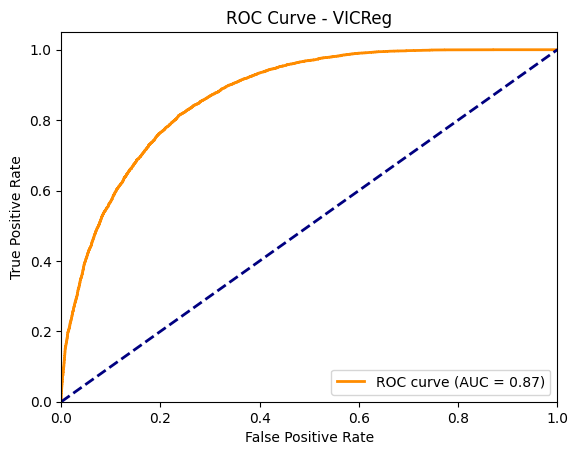

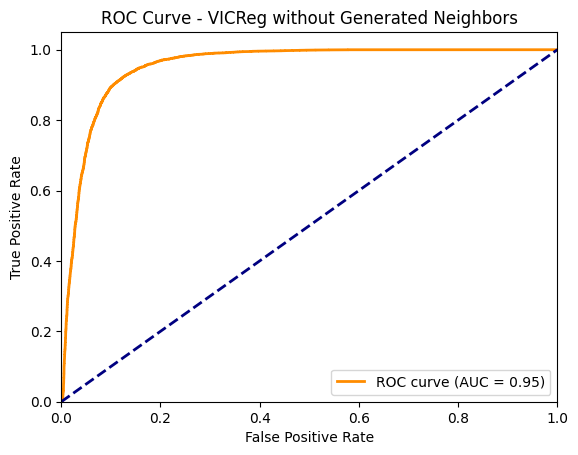

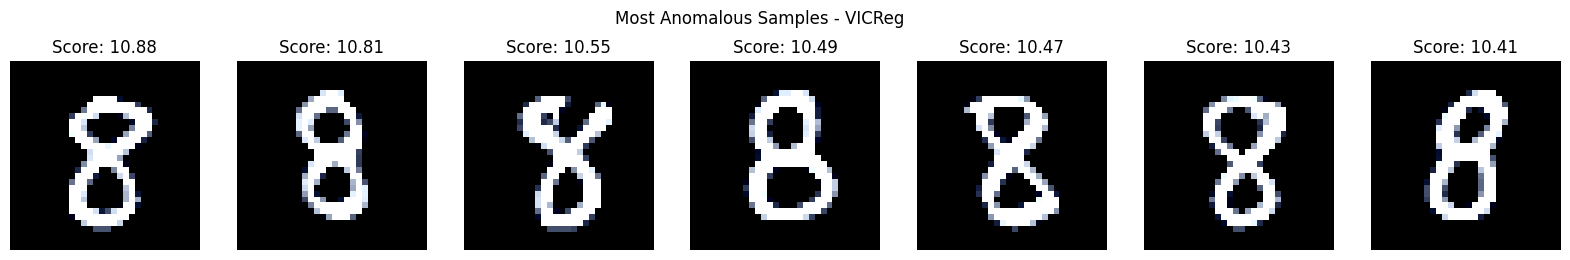

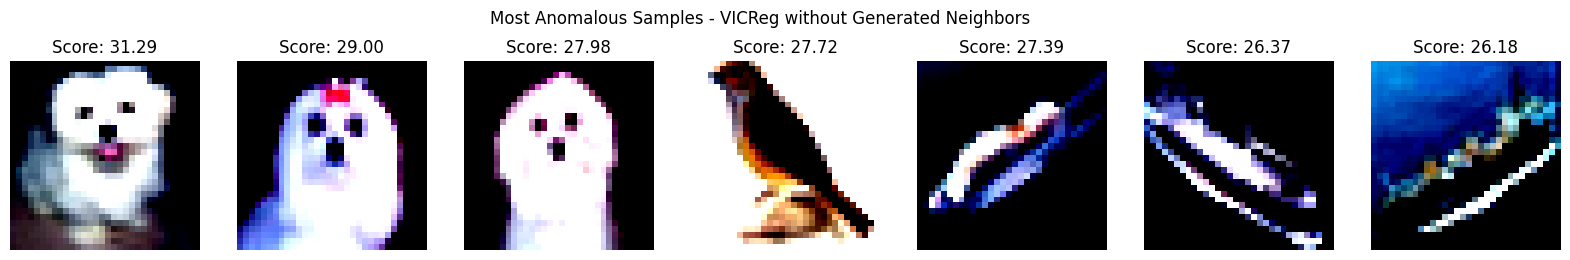

VICReg AUC: 0.8705
VICReg without Generated Neighbors AUC: 0.9531


In [7]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def grayscale_to_rgb(image):
    return image.convert("RGB")

def compute_representations(model, dataloader, device):
    model.eval()
    representations = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reps = model.encoder.encode(images)
            representations.append(reps.cpu().numpy())
    return np.concatenate(representations)

def knn_density_estimation(train_reps, test_reps, k=2):
    nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
    nn.fit(train_reps)
    distances, _ = nn.kneighbors(test_reps)
    return np.mean(distances[:, 1:], axis=1)  # Exclude the first neighbor (self)

def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

def plot_anomalous_samples(images, scores, title, n=7):
    most_anomalous = np.argsort(scores)[-n:][::-1]
    plt.figure(figsize=(20, 3))
    for i, idx in enumerate(most_anomalous):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(f"Score: {scores[idx]:.2f}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Load datasets and models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Lambda(grayscale_to_rgb),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_test_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=256, shuffle=False)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=256, shuffle=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=256, shuffle=False)

vicreg_model = VicReg(D=128, proj_dim=512, device=device).to(device)
vicreg_model.load_state_dict(torch.load('./vicreg_model.pth'))

vicreg_nn_model = VicReg(D=128, proj_dim=512, device=device).to(device)
vicreg_nn_model.load_state_dict(torch.load('./nn_vicreg_model.pth'))

# Compute representations
train_reps = compute_representations(vicreg_model, cifar10_train_loader, device)
test_reps_cifar10_vicreg = compute_representations(vicreg_model, cifar10_test_loader, device)
test_reps_mnist_vicreg = compute_representations(vicreg_model, mnist_test_loader, device)
test_reps_cifar10_no_neighbors = compute_representations(vicreg_nn_model, cifar10_test_loader, device)
test_reps_mnist_no_neighbors = compute_representations(vicreg_nn_model, mnist_test_loader, device)

# Concatenate test representations
test_reps_vicreg = np.concatenate([test_reps_cifar10_vicreg, test_reps_mnist_vicreg])
test_reps_no_neighbors = np.concatenate([test_reps_cifar10_no_neighbors, test_reps_mnist_no_neighbors])

# Compute anomaly scores
scores_vicreg = knn_density_estimation(train_reps, test_reps_vicreg)
scores_no_neighbors = knn_density_estimation(train_reps, test_reps_no_neighbors)

# Create labels (0 for CIFAR10, 1 for MNIST)
y_true = np.concatenate([np.zeros(len(test_reps_cifar10_vicreg)), np.ones(len(test_reps_mnist_vicreg))])

# Plot ROC curves
plot_roc_curve(y_true, scores_vicreg, "VICReg")
plot_roc_curve(y_true, scores_no_neighbors, "VICReg without Generated Neighbors")

# Plot most anomalous samples
test_images_cifar10 = torch.cat([img for img, _ in cifar10_test_loader])
test_images_mnist = torch.cat([img for img, _ in mnist_test_loader])
test_images = torch.cat([test_images_cifar10, test_images_mnist], dim=0)
plot_anomalous_samples(test_images, scores_vicreg, "Most Anomalous Samples - VICReg")
plot_anomalous_samples(test_images, scores_no_neighbors, "Most Anomalous Samples - VICReg without Generated Neighbors")

# Print comparison
print(f"VICReg AUC: {auc(roc_curve(y_true, scores_vicreg)[0], roc_curve(y_true, scores_vicreg)[1]):.4f}")
print(f"VICReg without Generated Neighbors AUC: {auc(roc_curve(y_true, scores_no_neighbors)[0], roc_curve(y_true, scores_no_neighbors)[1]):.4f}")


# Clustring - Bonus

In [5]:
from sklearn.cluster import KMeans

vicreg_model = VicReg(D=128, proj_dim=512, device=device).to(device)
vicreg_model.load_state_dict(torch.load('/kaggle/working/vicreg_model.pth'))

vicreg_nn_model = VicReg(D=128, proj_dim=512, device=device).to(device)
vicreg_nn_model.load_state_dict(torch.load('/kaggle/working/nn_vicreg_model.pth'))

def compute_clustering_representations(model, dataloader, device):
    model.eval()
    representations = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Computing representations"):
            images = images.to(device)
            reps = model.encoder.encode(images)
            representations.append(reps.cpu().numpy())
            labels.extend(targets.numpy())
    return np.concatenate(representations), np.array(labels)

cifar10_train = datasets.CIFAR10(root='/kaggle/input/cifer-10', train=True, download=False, transform=test_transform)
train_loader = DataLoader(cifar10_train, batch_size=256, shuffle=False)

# Compute representations for both models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vicreg_reps, true_labels = compute_clustering_representations(vicreg_model, train_loader, device)
vicreg_nn_reps, _ = compute_clustering_representations(vicreg_nn_model, train_loader, device)

# Perform K-means clustering
kmeans_vicreg = KMeans(n_clusters=10, random_state=42,n_init='auto')
kmeans_vicreg_nn = KMeans(n_clusters=10, random_state=42, n_init='auto')

vicreg_clusters = kmeans_vicreg.fit(vicreg_reps)
vicreg_nn_clusters = kmeans_vicreg_nn.fit(vicreg_nn_reps)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Computing representations:   0%|          | 0/196 [00:00<?, ?it/s]

Computing representations:   0%|          | 0/196 [00:00<?, ?it/s]

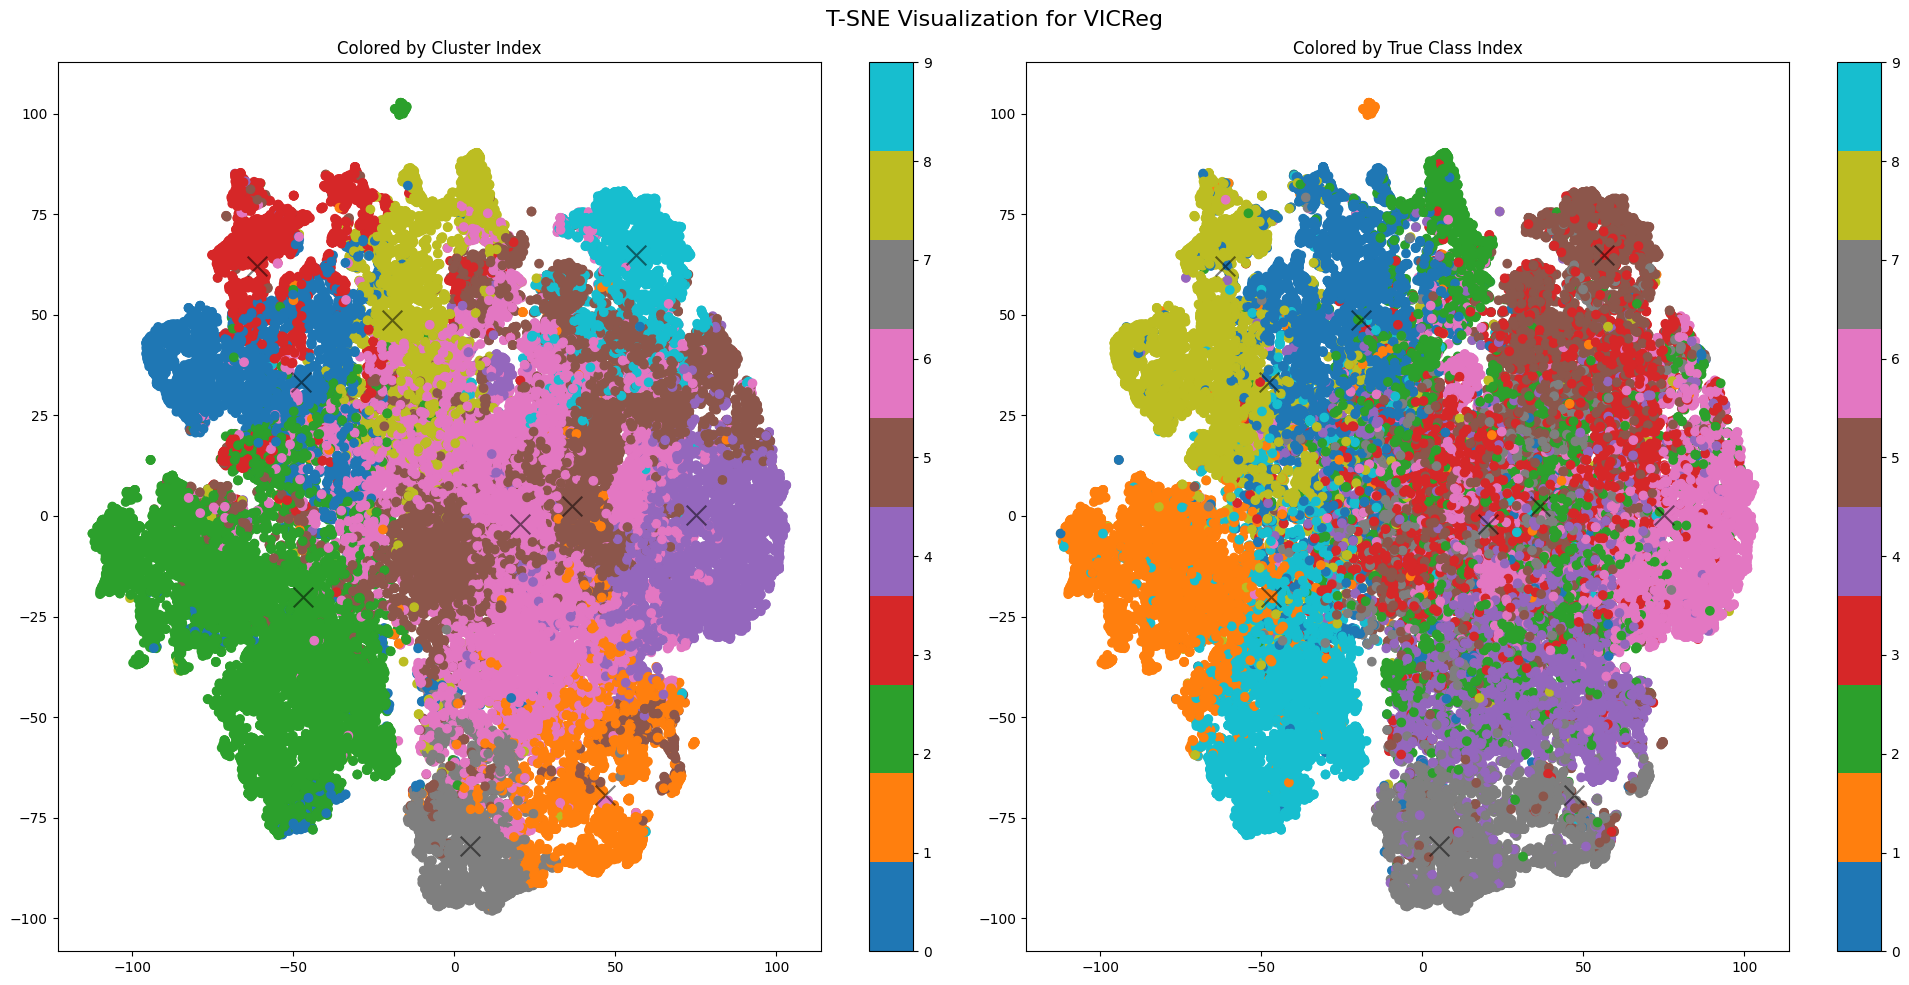

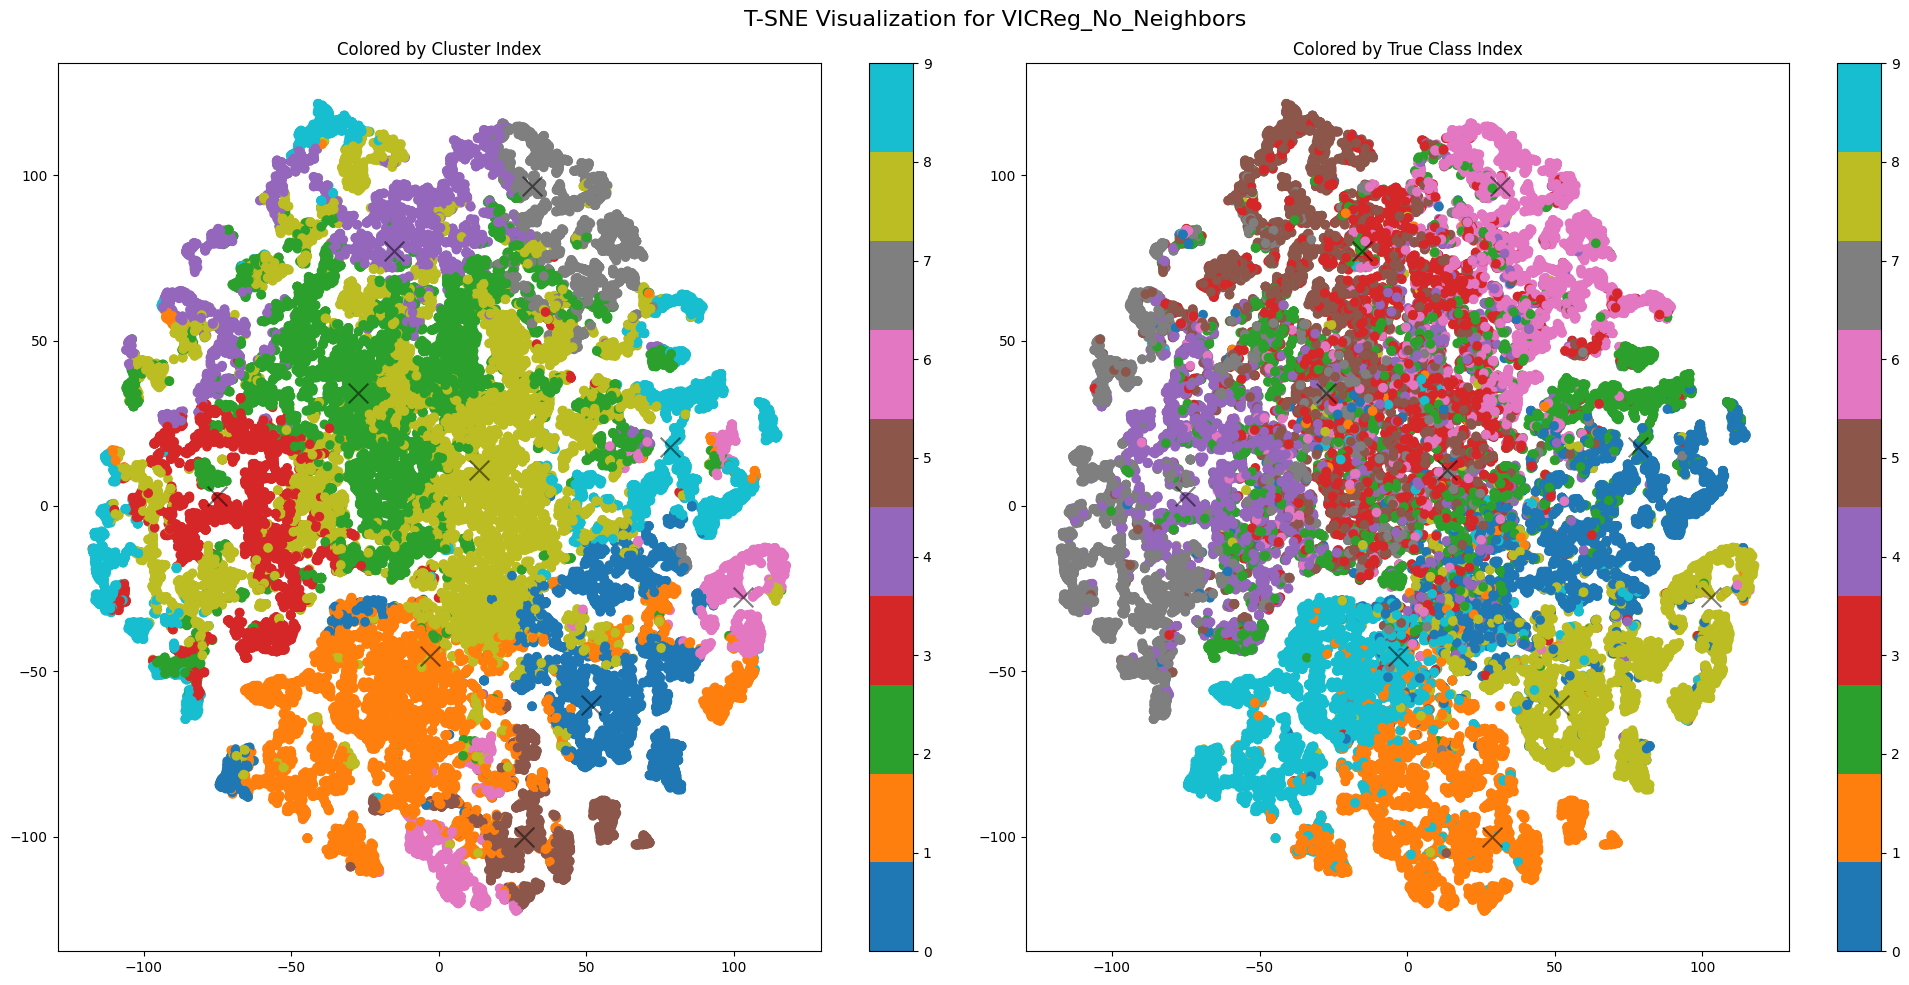

In [11]:
from sklearn.manifold import TSNE

def plot_tsne(representations, kmeans, true_labels, model_name):
    # Combine representations and cluster centers
    combined_data = np.vstack((representations, kmeans.cluster_centers_))
    
    # Perform T-SNE on combined data
    tsne = TSNE(n_components=2, random_state=42)
    combined_2d = tsne.fit_transform(combined_data)
    
    # Separate the results
    representations_2d = combined_2d[:len(representations)]
    centers_2d = combined_2d[len(representations):]
    
    # Get cluster labels
    kmeans_labels = kmeans.predict(representations)
    
    # Plot settings
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f'T-SNE Visualization for {model_name}', fontsize=16)
    
    # Plot colored by cluster index
    scatter1 = ax1.scatter(representations_2d[:, 0], representations_2d[:, 1], c=kmeans_labels, cmap='tab10')
    ax1.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, alpha=0.5, marker='x')
    ax1.set_title('Colored by Cluster Index')
    plt.colorbar(scatter1, ax=ax1)
    
    # Plot colored by true class index
    scatter2 = ax2.scatter(representations_2d[:, 0], representations_2d[:, 1], c=true_labels, cmap='tab10')
    ax2.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, alpha=0.5, marker='x')
    ax2.set_title('Colored by True Class Index')
    plt.colorbar(scatter2, ax=ax2)
    
    plt.tight_layout()
    plt.show()



plot_tsne(vicreg_reps, kmeans_vicreg, true_labels, "VICReg")
plot_tsne(vicreg_nn_reps, kmeans_vicreg_nn, true_labels, "VICReg_No_Neighbors")